#**Tarea Métodos Avanzados - House Prices - Advanced Regression Techniques**

Prediga precios de venta y practique Feature Engineering, RF y gradient boosting.

Pídale a un comprador que describa la casa de sus sueños y probablemente no comenzará con la altura del techo del sótano o la proximidad a una vía de ferrocarril de este a oeste. Pero el conjunto de datos de esta competición de parques infantiles demuestra que en las negociaciones de precios influye mucho más que el número de dormitorios o una valla blanca.

Con 79 variables explicativas que describen (casi) todos los aspectos de las viviendas residenciales en Ames, Iowa, esta competencia lo desafía a predecir el precio final de cada vivienda.

In [ ]:
#Preparando librerias
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn import metrics

<ipython-input-1-2b0c9a2df144>:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [ ]:
#Cargar data de entrenamiento y pruebas
#True: Google Colab | False: Kaggle
notebook_type = True

if notebook_type == True:
  #Para conectar Google Drive a nuestro notebook
  ! pip install pyreadstat
  from google.colab import drive
  drive.mount('/content/drive/')

  #Leer datasets
  df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Módulo 08/Tareas/train.csv')
  df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Módulo 08/Tareas/test.csv')

elif notebook_type == False:
  #Armar rutas en input del proyecto
  ruta_train = '../input/house-prices-advanced-regression-techniques/train.csv'
  ruta_test = '../input/house-prices-advanced-regression-techniques/test.csv'

  #Leer datasets
  df_train = pd.read_csv(ruta_train)
  df_test = pd.read_csv(ruta_test)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.6 MB/s eta 0:00:00
Mounted at /content/drive/


In [ ]:
df_train.head(3)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  

[3 rows x 81 columns]

In [ ]:
df_test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

##1 - **Análisis Exploratorio de Datos (EDA) y preparación de los datos**

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

A continuación la descripción de cada variable:

* **MSSubClass**: Identifica el tipo de vivienda involucrada en la venta.
* **MSZoning**: Identifica la clasificación general de zonificación de la venta.
* **LotFrontage**: Pies lineales de calle conectados a la propiedad
* **LotArea**: Tamaño del lote en pies cuadrados
* **Calle**: Tipo de vía de acceso a la propiedad   
* **Callejón**: Tipo de callejón de acceso a la propiedad.
* **LotShape**: Forma general de la propiedad    
* **LandContour**: Planitud de la propiedad
* **Utilities**: Tipo de utilidades disponibles
* **LotConfig**: configuración del lote
* **LandSlope**: Pendiente de la propiedad
* **Neighborhood**: ubicaciones físicas dentro de los límites de la ciudad de Ames
* **Condition1**: Proximidad a varias condiciones.
* **Condition2**: Proximidad a varias condiciones (si hay más de una)
* **BldgType**: Tipo de vivienda
* **HouseStyle**: Estilo de vivienda
* **GeneralQual**: Califica el material y el acabado general de la casa.
* **GeneralCond**: Califica el estado general de la casa.
* **YearBuilt**: Fecha de construcción original
* **YearRemodAdd**: fecha de remodelación (igual que la fecha de construcción si no hay remodelaciones ni adiciones)
* **RoofStyle**: Tipo de techo
* **RoofMatl**: Material del tejado
* **Exterior1st**: Revestimiento exterior de la casa.
* **Exterior2nd**: Revestimiento exterior de la casa (si hay más de un material)
* **MasVnrType**: Tipo de revestimiento de mampostería
* **MasVnrArea**: Área de revestimiento de mampostería en pies cuadrados
* **ExterQual**: Evalúa la calidad del material en el exterior
* **ExterCond**: Evalúa el estado actual del material en el exterior.
* **Foundation**: Tipo de cimentación
* **BsmtQual**: Evalúa la altura del sótano.
* **BsmtCond**: Evalúa el estado general del sótano.
* **BsmtExposure**: Se refiere a paredes a nivel de jardín o de salida.
* **BsmtFinType1**: Clasificación del área terminada del sótano
* **BsmtFinSF1**: Pies cuadrados acabados tipo 1
* **BsmtFinType2**: Clasificación del área terminada del sótano (si hay varios tipos)
* **BsmtFinSF2**: Pies cuadrados acabados tipo 2
* **BsmtUnfSF**: Metros cuadrados de sótano sin terminar
* **TotalBsmtSF**: Pies cuadrados totales de área del sótano
* **Heating**: Tipo de calefacción
* **HeatingQC**: Calidad y estado de la calefacción
* **CentralAir**: aire acondicionado centralizado
* **Electrical**: Sistema eléctrico
* **1stPlrSF**: Pies cuadrados del primer piso
* **2ndFlrSF**: Pies cuadrados del segundo piso
* **LowQualFinSF**: Pies cuadrados con acabado de baja calidad (todos los pisos)
* **GrLivArea**: superficie habitable sobre el nivel del suelo (pies cuadrados)
* **BsmtFullBath**: Baños completos en sótano
* **BsmtHalfBath**: Medios baños del sótano
* **FullBath**: Baños completos sobre el nivel del suelo.
* **HalfBath**: Medios baños sobre el nivel del suelo.
* **Bedroom**: Dormitorios sobre el nivel del suelo (NO incluye dormitorios en el sótano)
* **Kitchen**: Cocinas por encima del nivel del suelo.
* **KitchenQual**: Calidad de cocina
* **TotRmsAbvGrd**: Total de habitaciones sobre rasante (no incluye baños)
* **Functional**: funcionalidad del hogar (suponga que es típico a menos que se justifiquen deducciones)
* **Fireplaces**: Número de chimeneas
* **FireplaceQu**: Calidad de chimenea
* **GarageType**: Ubicación del garaje
* **GarageYrBlt**: Año de construcción del garaje.
* **GarageFinish**: Acabado interior del garaje.
* **GarageCars**: Tamaño del garaje en capacidad de coches.
* **GarageArea**: tamaño del garaje en pies cuadrados
* **GarageQual**: Calidad del garaje
* **GarageCond**: Estado del garaje
* **PavedDrive**: camino pavimentado
* **WoodDeckSF**: Área de cubierta de madera en pies cuadrados
* **OpenPorchSF**: Área de porche abierto en pies cuadrados
* **Porche cerrado**: área del porche cerrado en pies cuadrados
* **3SsnPorch**: Área de porche de tres estaciones en pies cuadrados
* **ScreenPorch**: área del porche cubierto en pies cuadrados
* **PoolArea**: Área de la piscina en pies cuadrados
* **PoolQC**: Calidad de la piscina
* **Valla**: Calidad de la valla
* **MiscFeature**: característica miscelánea no cubierta en otras categorías
* **MiscVal**: $Valor de característica miscelánea
* **MoVendido**: Mes vendido (MM)
* **YrSold**: Año vendido (AAAA)
* **SaleType**: Tipo de venta
* **SaleCondition**: Condición de venta

Observamos de info:

* Existen 43 columnas con el tipo de datos "objeto". Estas columnas representan características categóricas.
* Existen 3 columnas con el tipo de datos 'float64'. Estas columnas representan características de mediciones físicas.
* Existen 35 columnas con el tipo de datos 'int64'. Estas columnas representan características numéricas, siendo una de ellas nuestra característica objetivo, que es el precio de venta de la casa (SalesPrice).

In [ ]:
df_train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

A traves de describe podemos analizar rapidamente valores claves como mediana, media y los cuartiles.

In [ ]:
#Eliminando la variable "Id"
columns_to_drop = ['Id']
df_train = df_train.drop(columns_to_drop, axis=1)

In [ ]:
#Separando por tipo de datos las caracteristica
numeric_columns = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

###**Analizando las variables númericas**

In [ ]:
#Cantidad de Variables númercias
print("La cantidad de caracteristicas númericas es de:", len(numeric_columns))

La cantidad de caracteristicas númericas es de: 37


Analicemos la presencia de valores NA/caracteristica

In [ ]:
#Para variables numéricas
total_numeric = len(df_train)
nulls_numeric = (df_train[numeric_columns].isnull().sum() / total_numeric) * 100
print("Porcentaje de valores nulos para variables numéricas:")
print(nulls_numeric)

Porcentaje de valores nulos para variables numéricas:
MSSubClass        0.000000
LotFrontage      17.739726
LotArea           0.000000
OverallQual       0.000000
OverallCond       0.000000
YearBuilt         0.000000
YearRemodAdd      0.000000
MasVnrArea        0.547945
BsmtFinSF1        0.000000
BsmtFinSF2        0.000000
BsmtUnfSF         0.000000
TotalBsmtSF       0.000000
1stFlrSF          0.000000
2ndFlrSF          0.000000
LowQualFinSF      0.000000
GrLivArea         0.000000
BsmtFullBath      0.000000
BsmtHalfBath      0.000000
FullBath          0.000000
HalfBath          0.000000
BedroomAbvGr      0.000000
KitchenAbvGr      0.000000
TotRmsAbvGrd      0.000000
Fireplaces        0.000000
GarageYrBlt       5.547945
GarageCars        0.000000
GarageArea        0.000000
WoodDeckSF        0.000000
OpenPorchSF       0.000000
EnclosedPorch     0.000000
3SsnPorch         0.000000
ScreenPorch       0.000000
PoolArea          0.000000
MiscVal           0.000000
MoSold            0.000000
Y

Encontramos que existen 3 variables con presencia de variables nulos estas variables son:

*   LotFrontage: 17.73%
*   MasVnrArea: 0.54%
*   GarageYrBlt: 5.54%

Los porcentajes no son altos, veamos como distribuyen estas 3 variables...



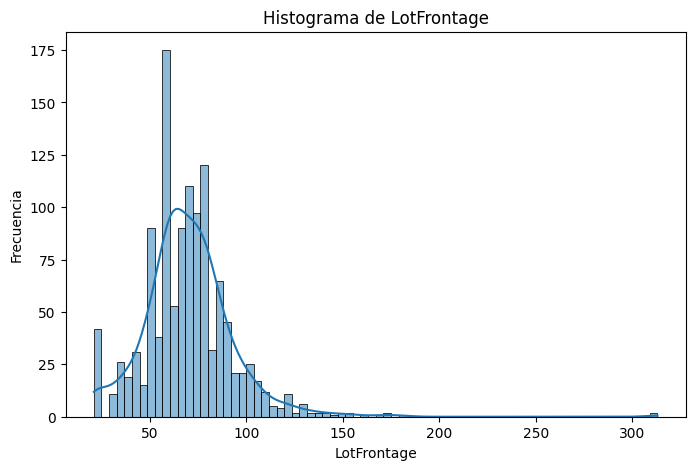

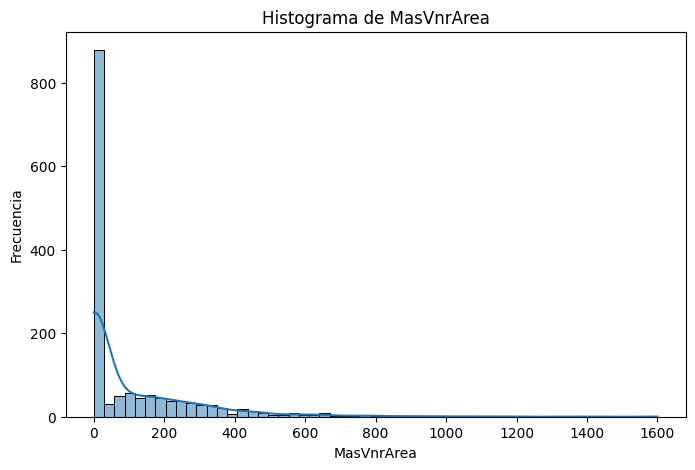

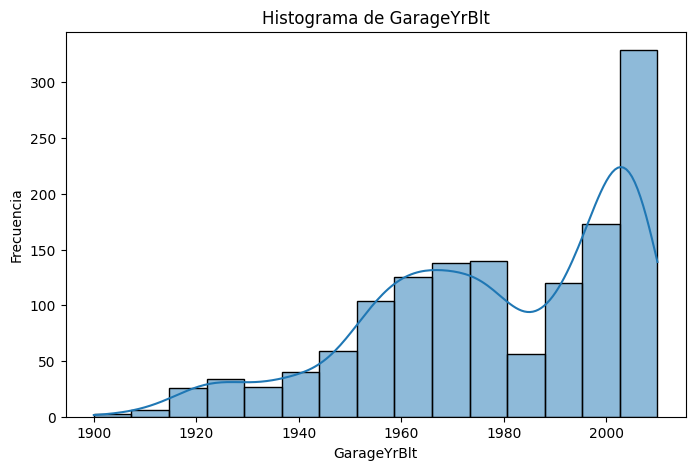

In [ ]:
#Histograma(s)
numeric_columns_na = ["LotFrontage", "MasVnrArea", "GarageYrBlt"]
for feature in numeric_columns_na:
    #Histrograma
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df_train, x=feature, kde=True)
    plt.title(f'Histograma de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')
    plt.show()

Imputando valores nulos a las variables identificadas con valor mayor a 0 utilizando la mediana debido a las asimetrias identificadas.

In [ ]:
#Imputación para variables numéricas
for column in numeric_columns:
    if df_train[column].isnull().sum() > 0:
        if df_train[column].dtype == 'int64' or df_train[column].dtype == 'float64':
            median_value = df_train[column].median()
            df_train[column].fillna(median_value, inplace=True)

In [ ]:
#Para variables numéricas
total_numeric = len(df_train)
nulls_numeric = (df_train[numeric_columns].isnull().sum() / total_numeric) * 100
print("Porcentaje de valores nulos para variables numéricas:")
print(nulls_numeric)

Porcentaje de valores nulos para variables numéricas:
MSSubClass       0.0
LotFrontage      0.0
LotArea          0.0
OverallQual      0.0
OverallCond      0.0
YearBuilt        0.0
YearRemodAdd     0.0
MasVnrArea       0.0
BsmtFinSF1       0.0
BsmtFinSF2       0.0
BsmtUnfSF        0.0
TotalBsmtSF      0.0
1stFlrSF         0.0
2ndFlrSF         0.0
LowQualFinSF     0.0
GrLivArea        0.0
BsmtFullBath     0.0
BsmtHalfBath     0.0
FullBath         0.0
HalfBath         0.0
BedroomAbvGr     0.0
KitchenAbvGr     0.0
TotRmsAbvGrd     0.0
Fireplaces       0.0
GarageYrBlt      0.0
GarageCars       0.0
GarageArea       0.0
WoodDeckSF       0.0
OpenPorchSF      0.0
EnclosedPorch    0.0
3SsnPorch        0.0
ScreenPorch      0.0
PoolArea         0.0
MiscVal          0.0
MoSold           0.0
YrSold           0.0
SalePrice        0.0
dtype: float64


Verificando ahora el resto de variables para identificar posibles presencia de outliers y distribuciones...

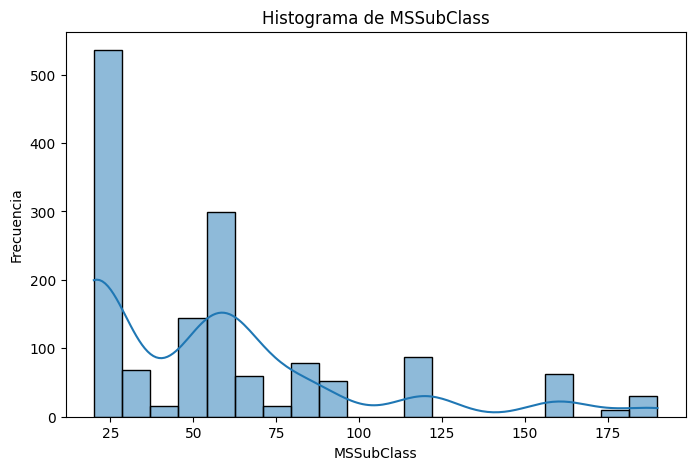

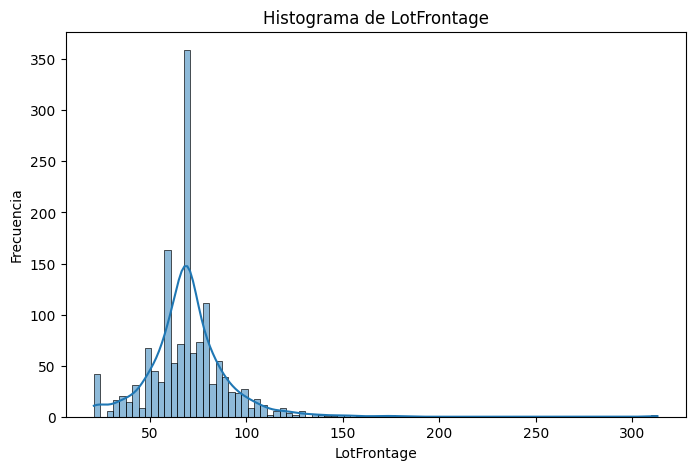

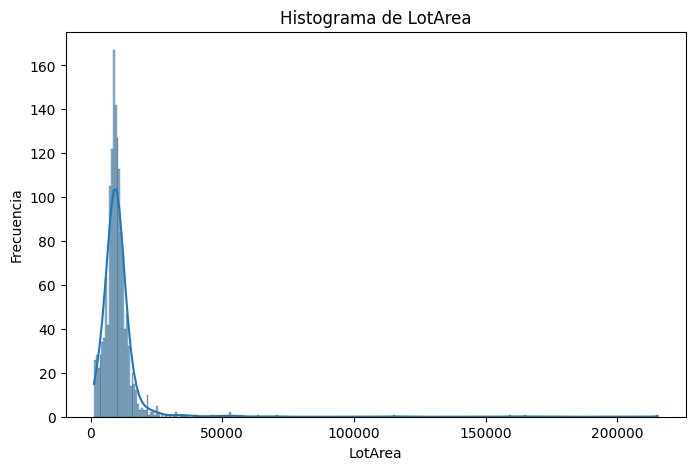

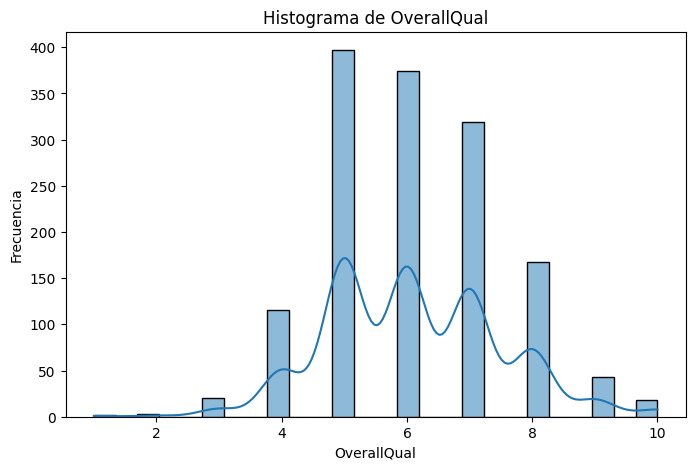

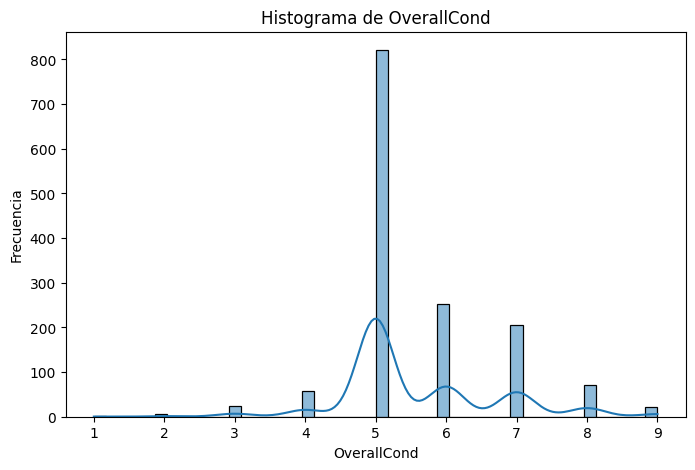

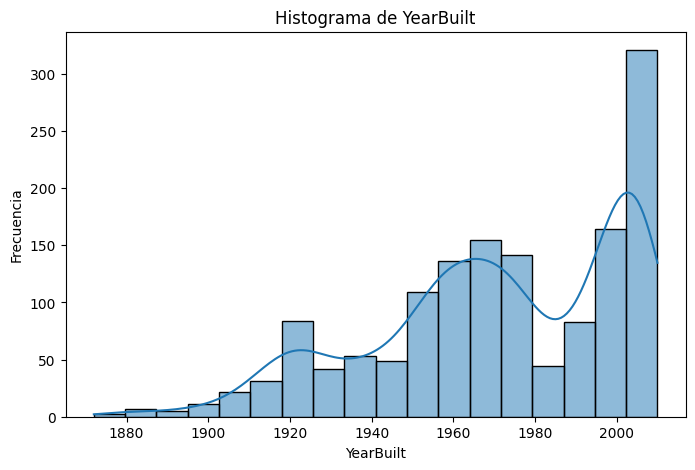

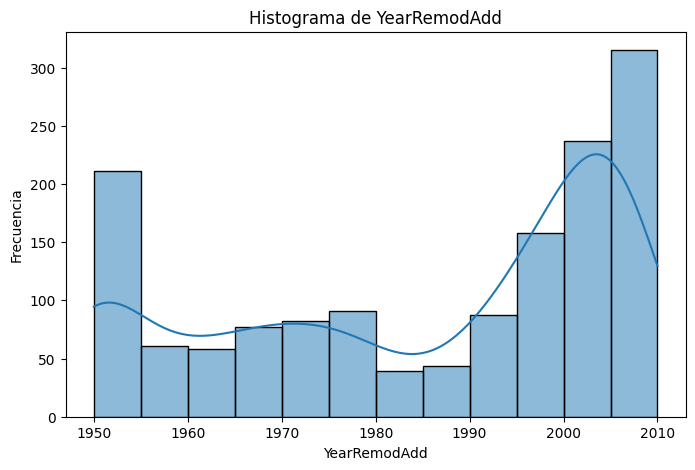

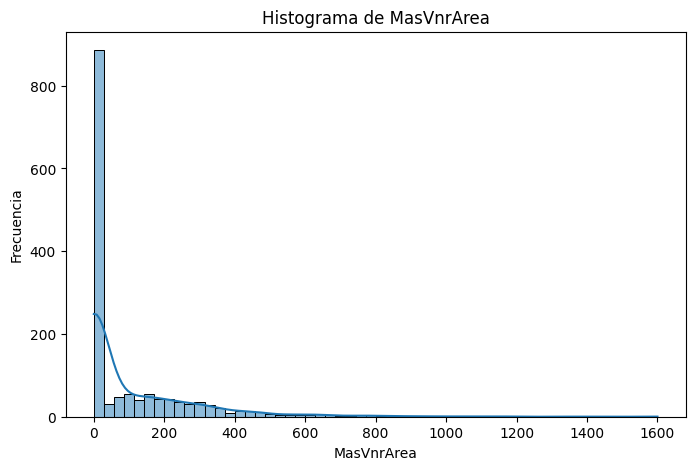

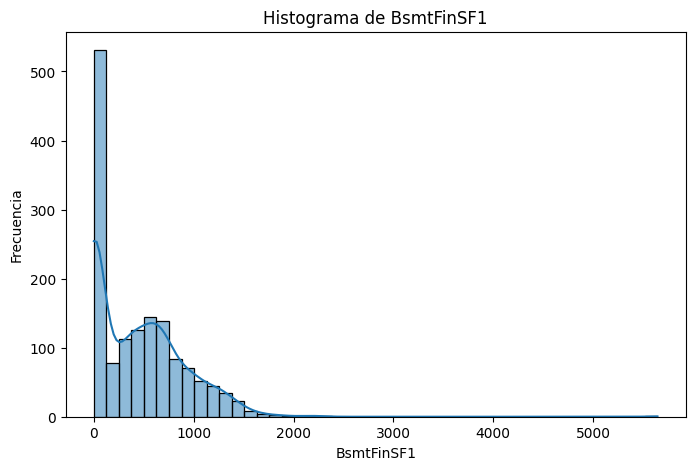

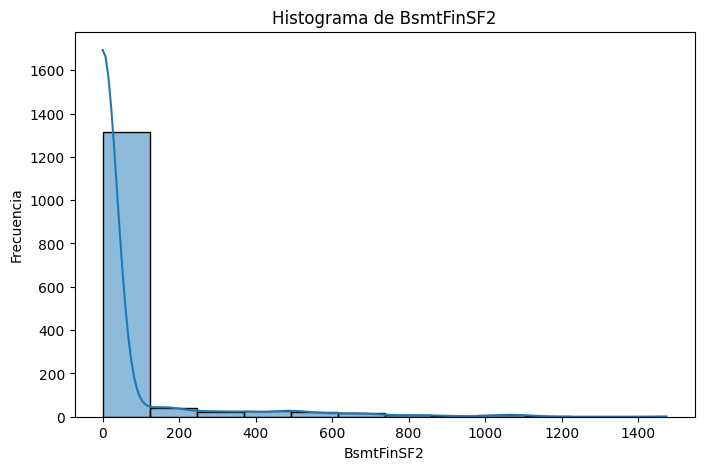

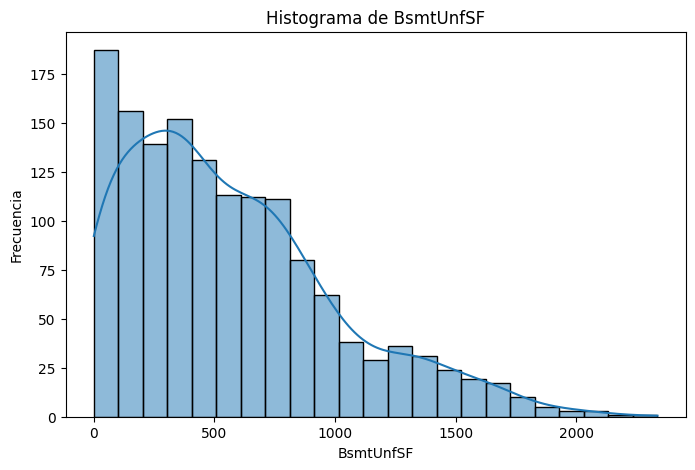

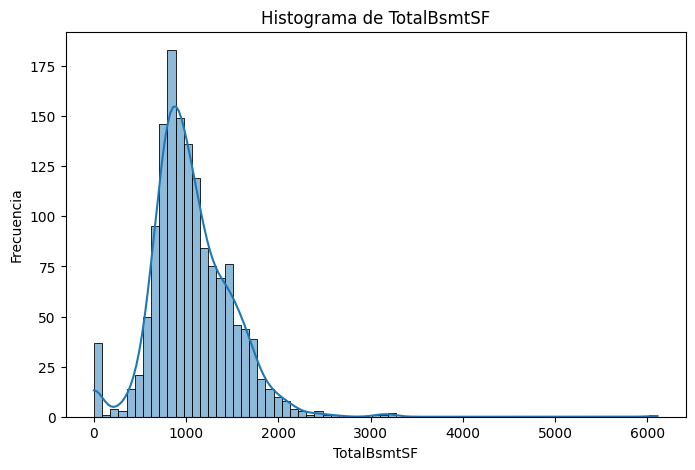

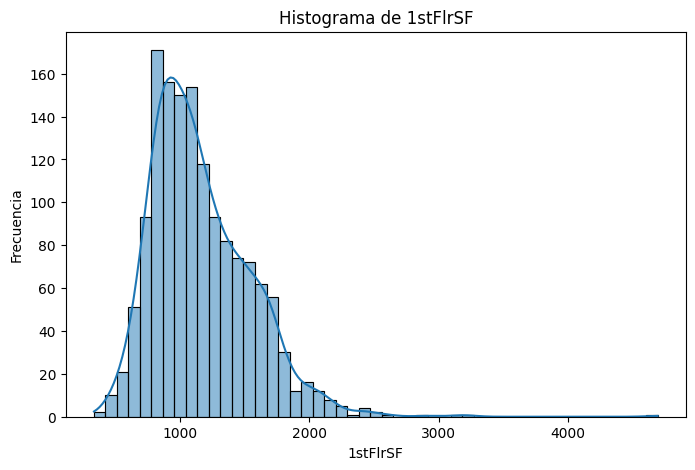

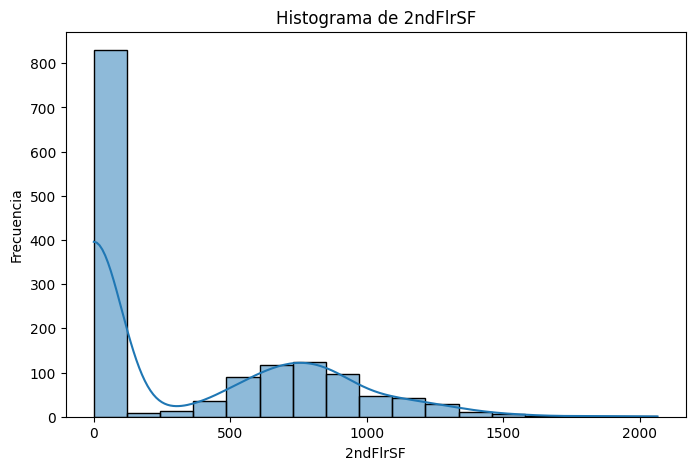

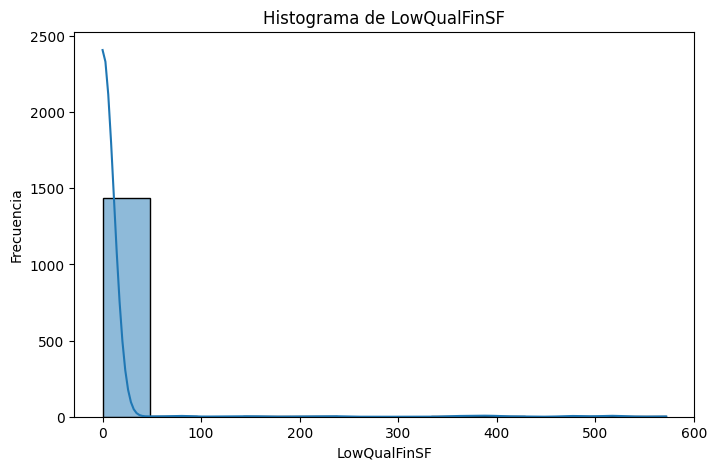

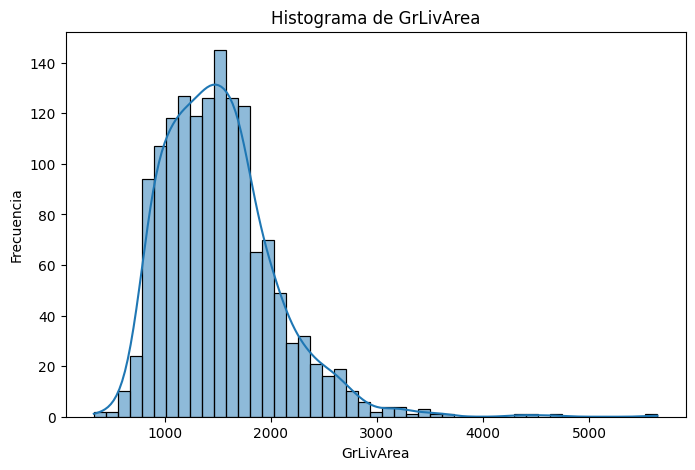

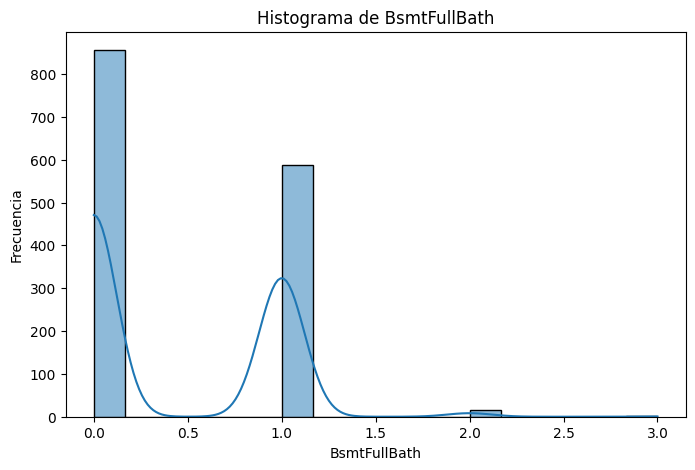

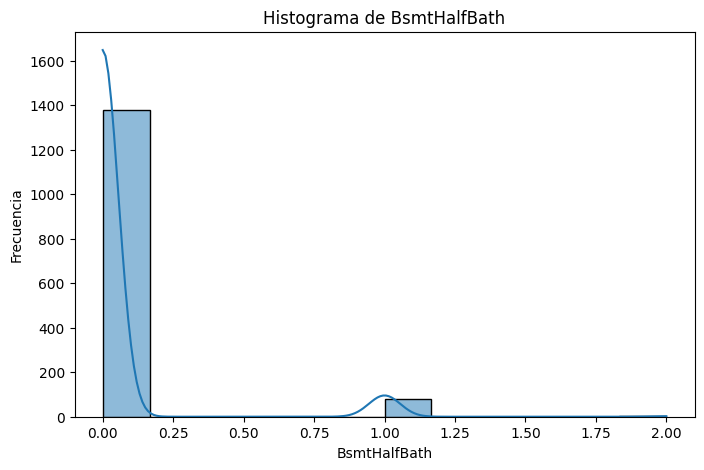

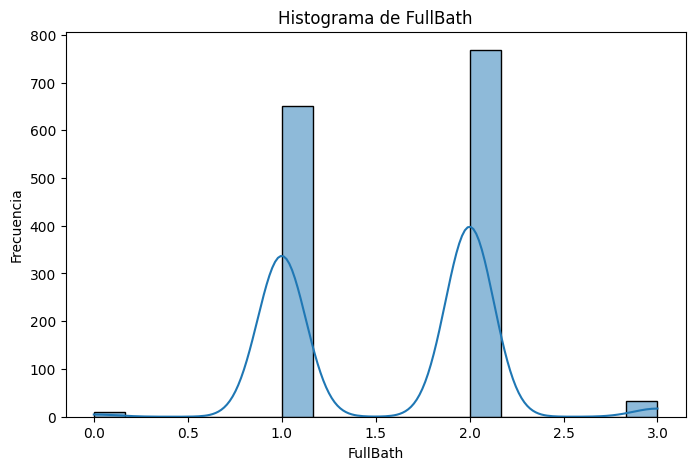

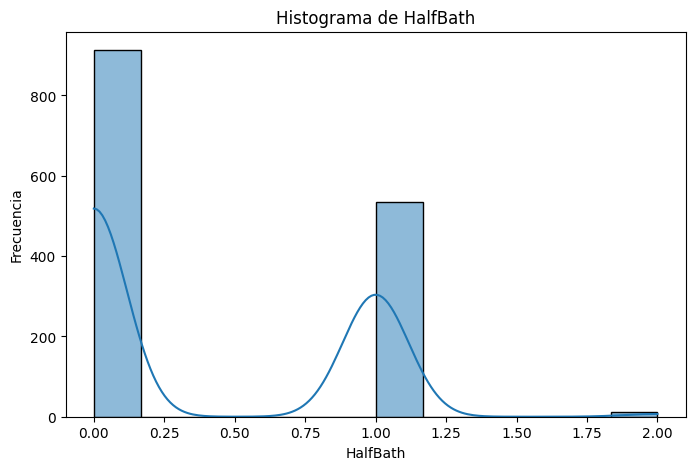

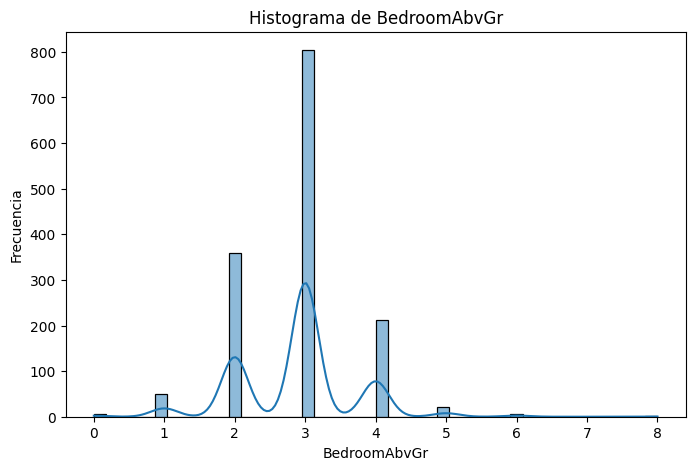

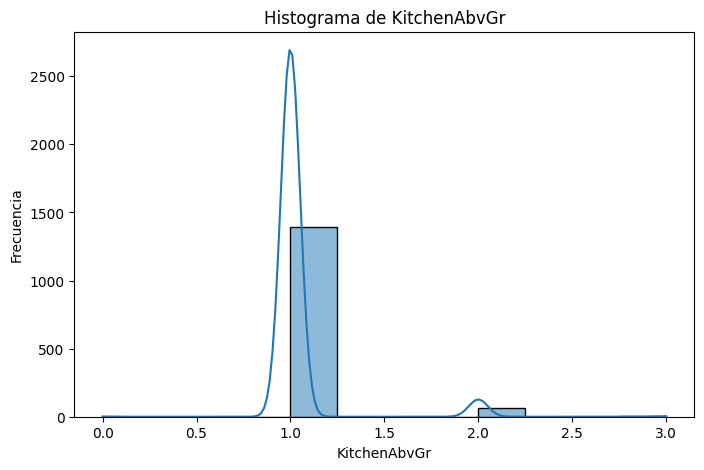

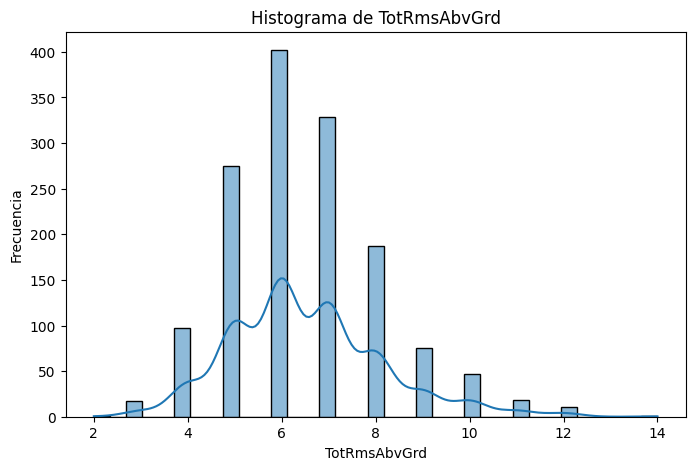

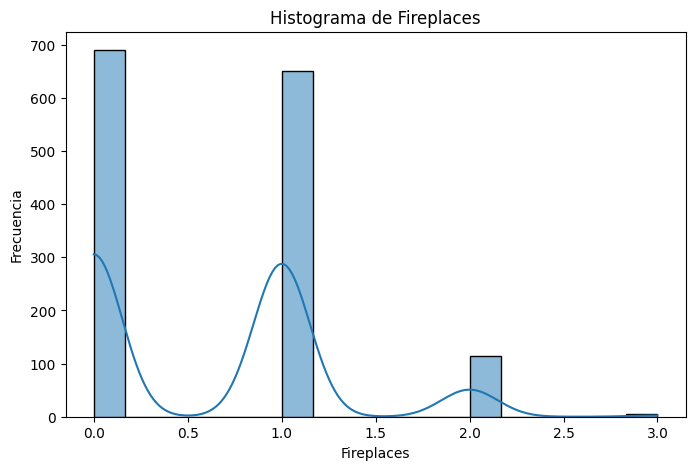

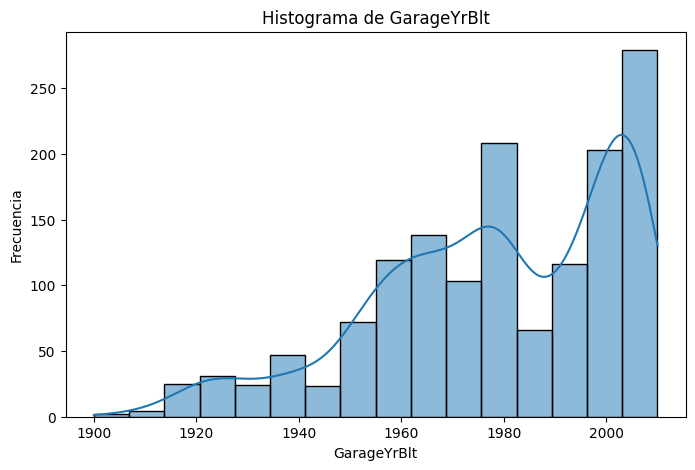

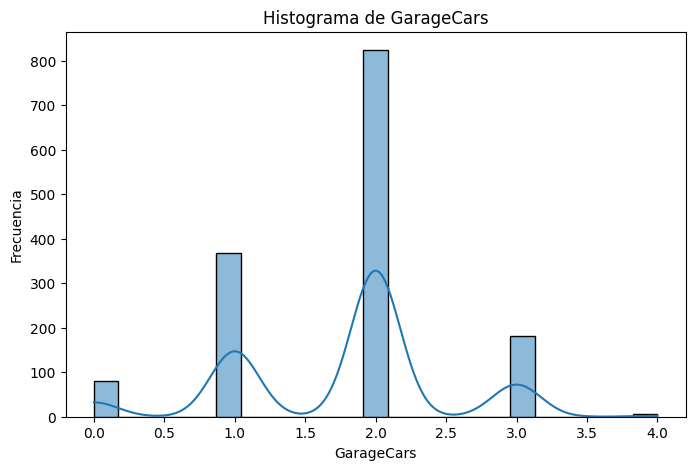

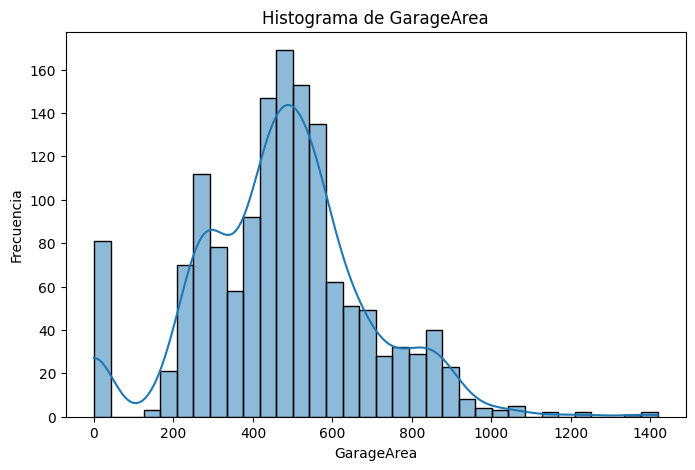

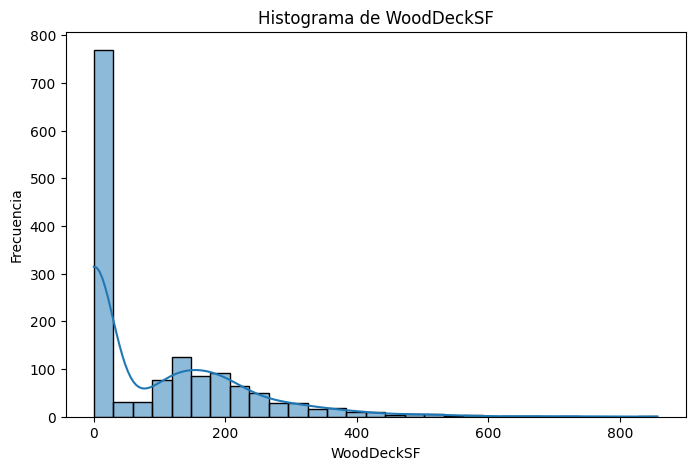

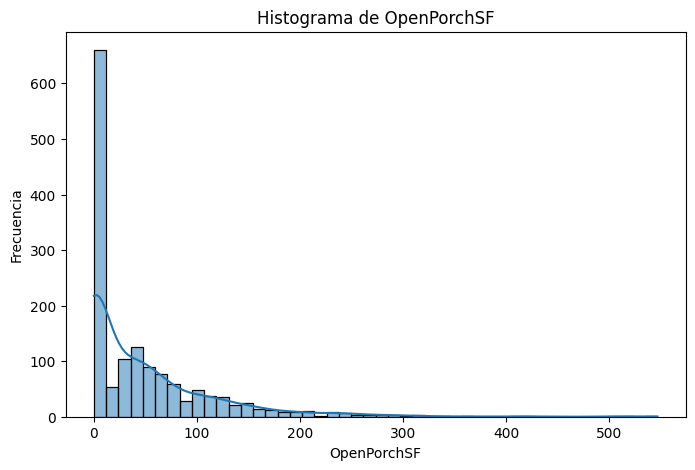

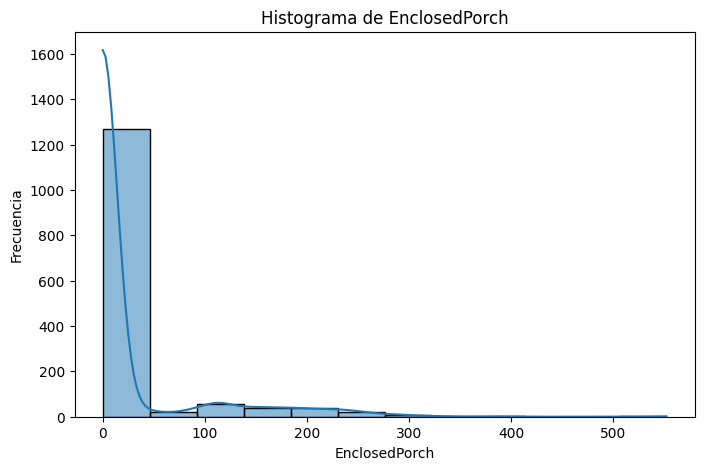

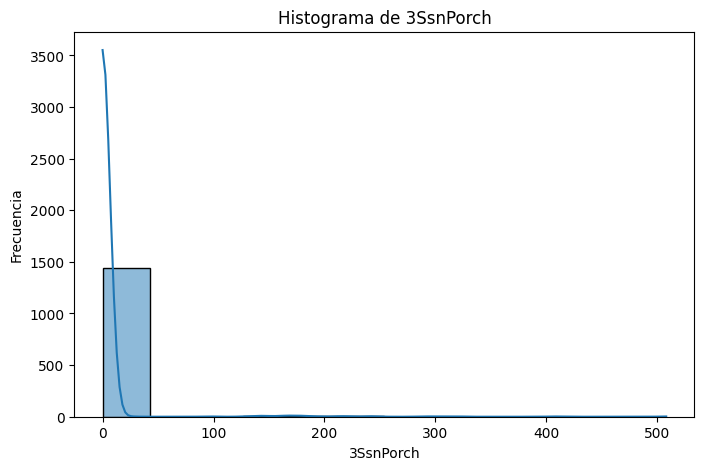

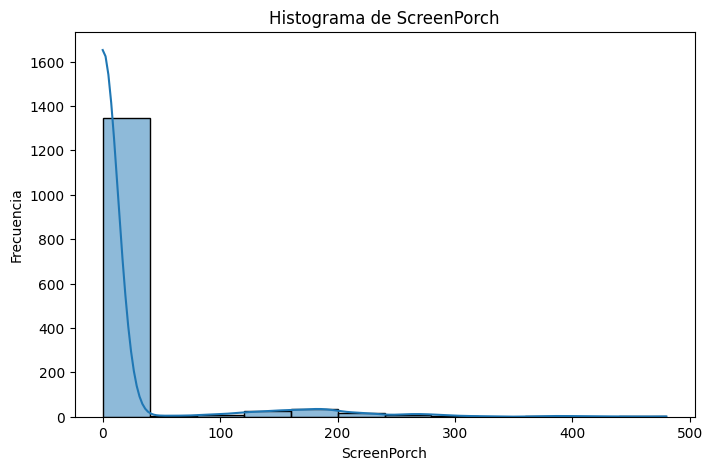

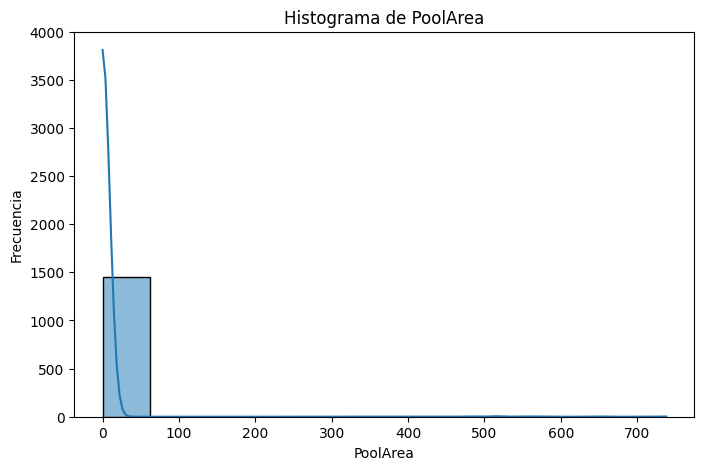

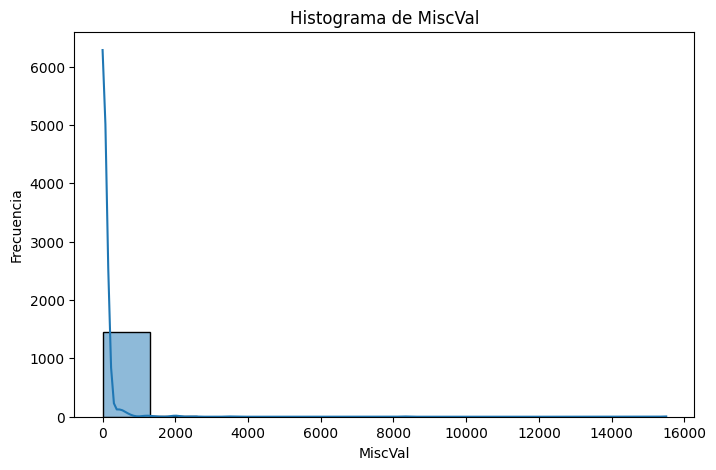

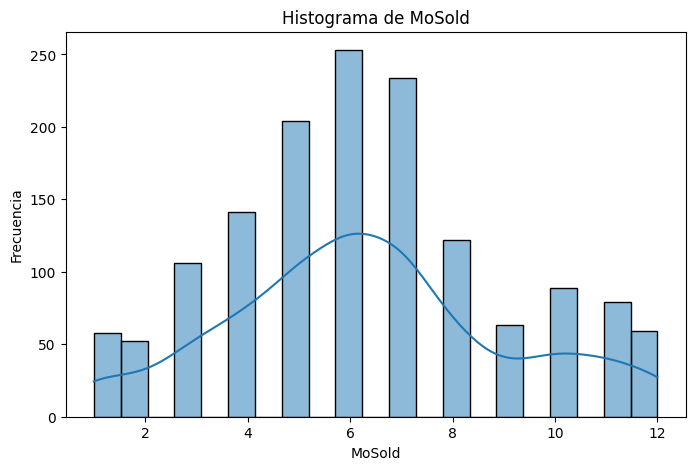

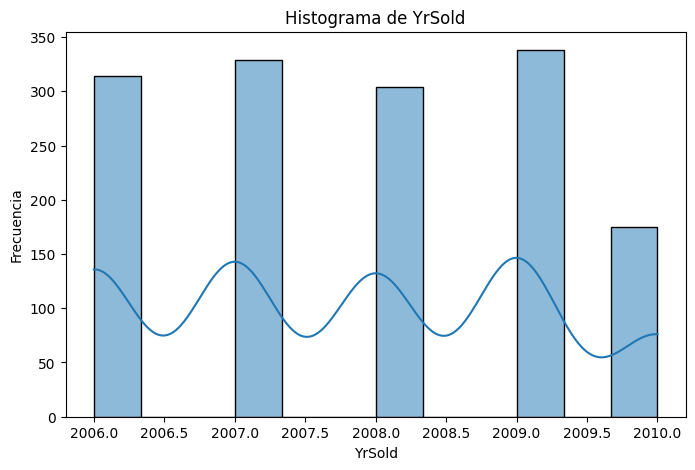

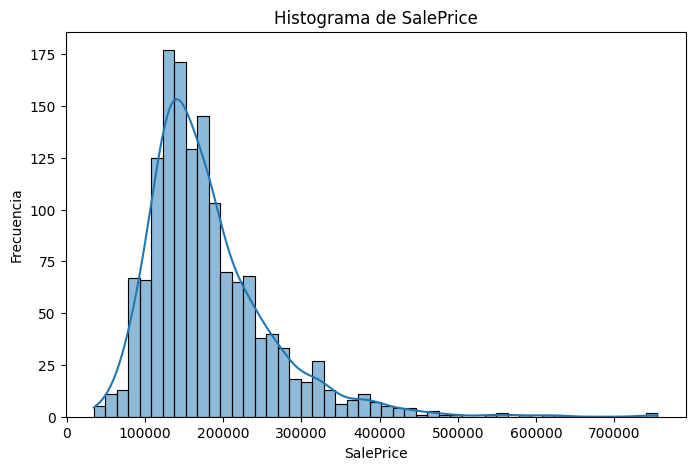

In [ ]:
#Para variables numéricas
for feature in numeric_columns:
  #Histrograma(s)
  plt.figure(figsize=(8, 5))
  sns.histplot(data=df_train, x=feature, kde=True)
  plt.title(f'Histograma de {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frecuencia')
  plt.show()

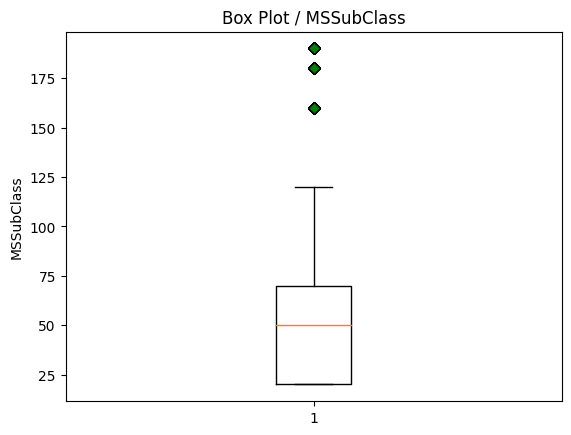

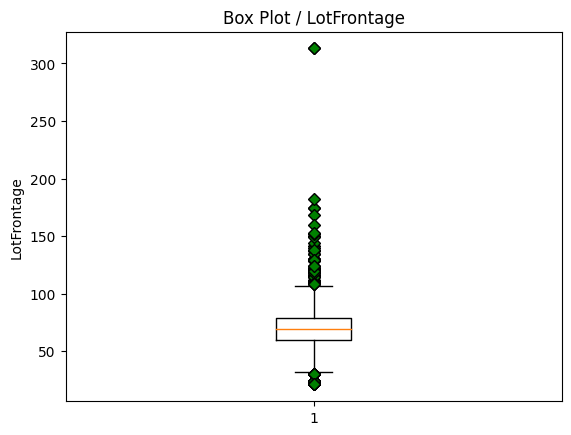

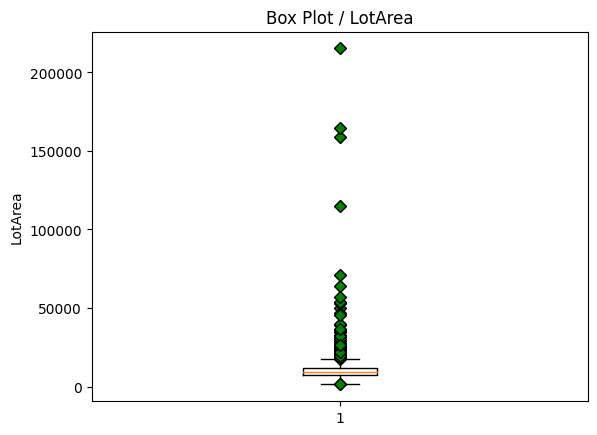

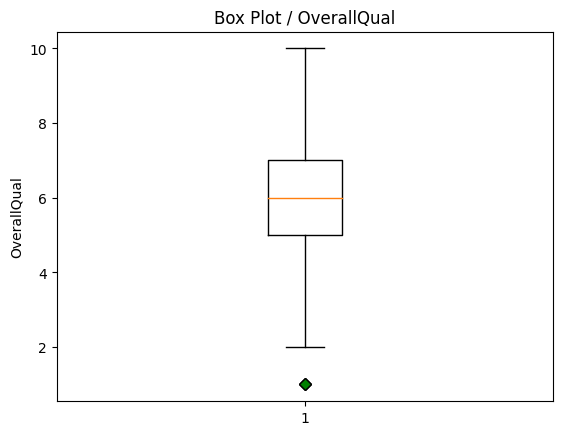

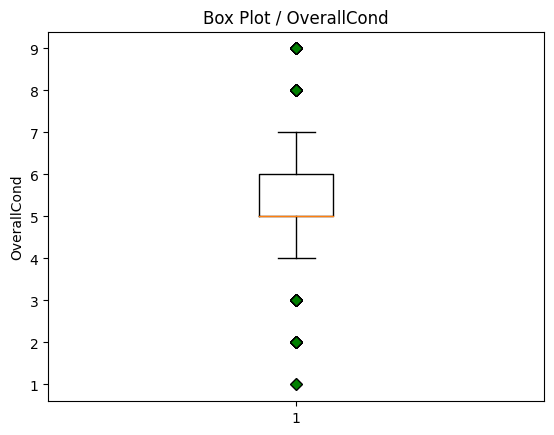

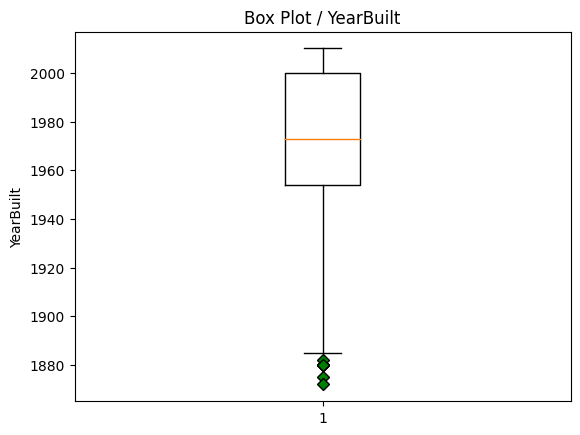

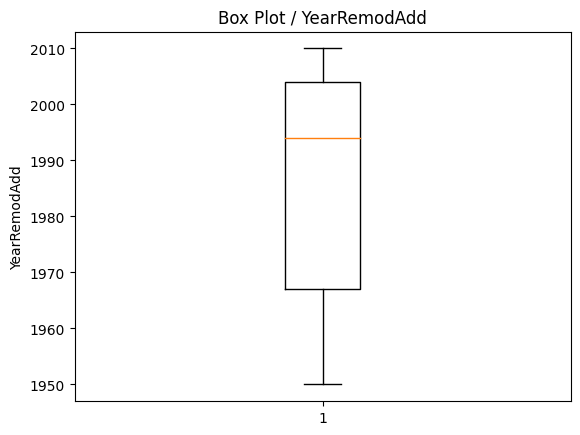

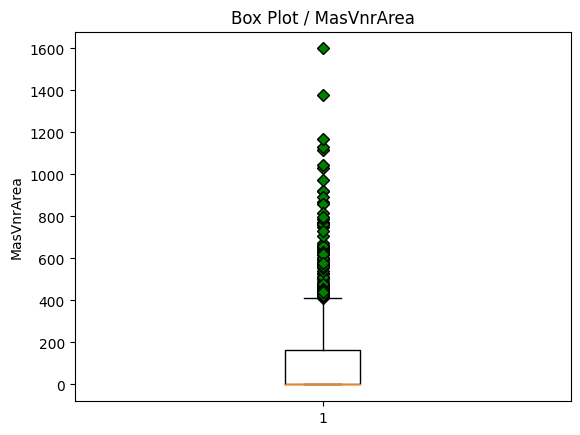

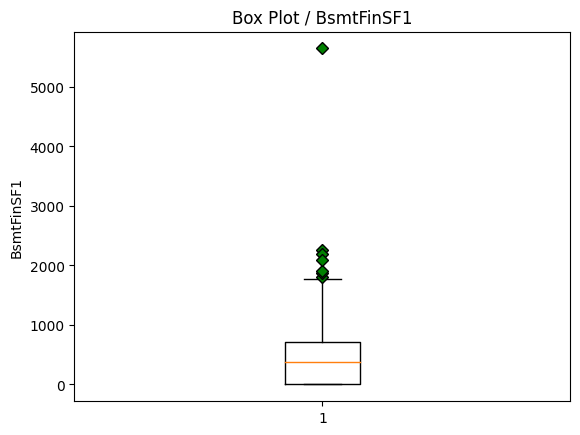

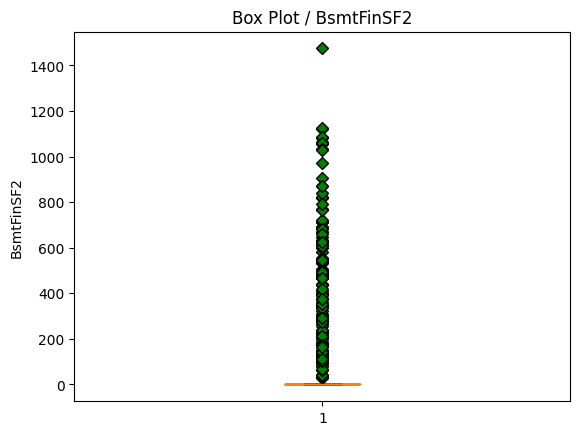

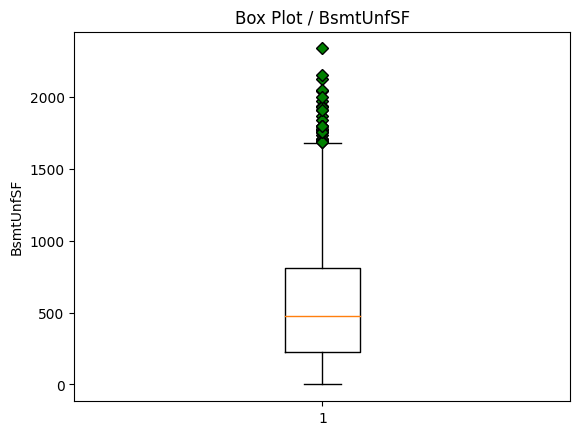

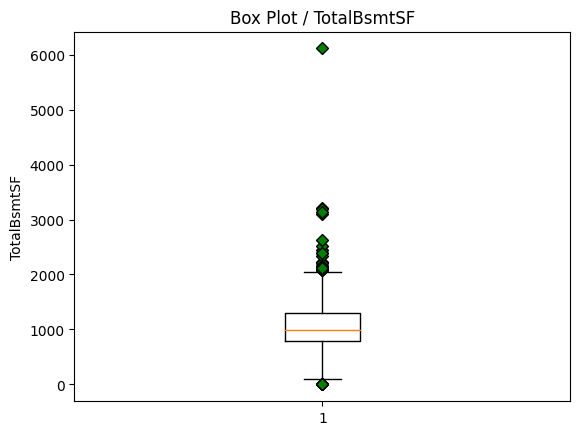

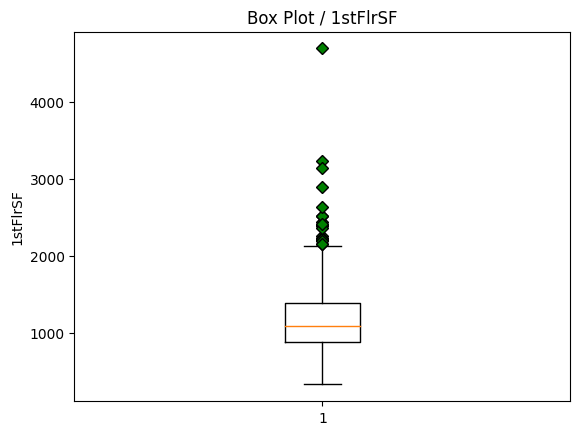

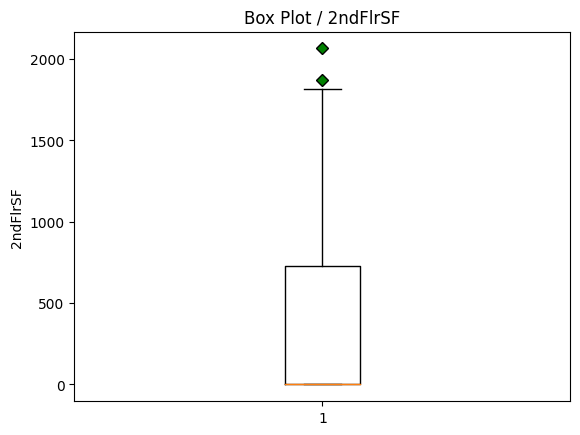

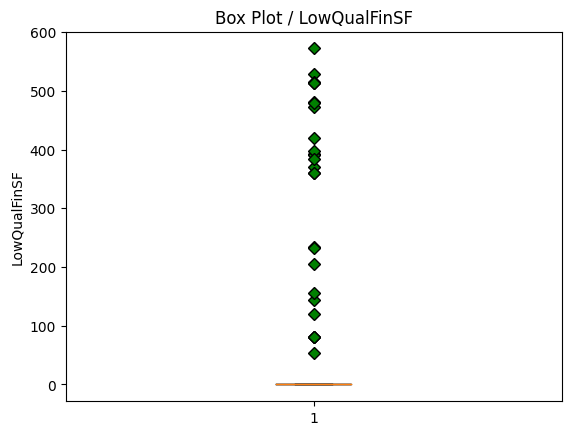

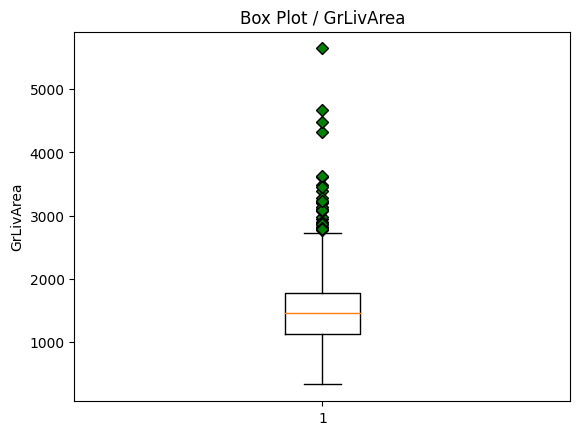

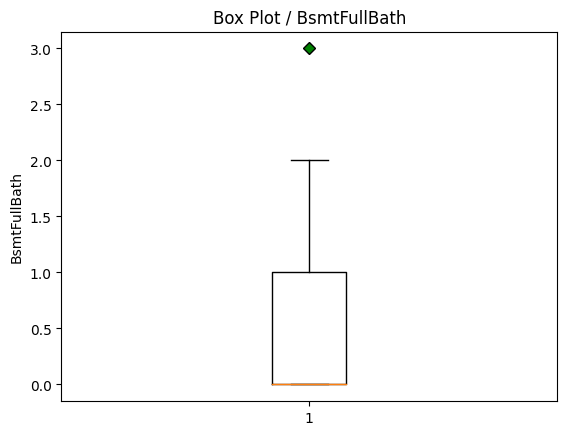

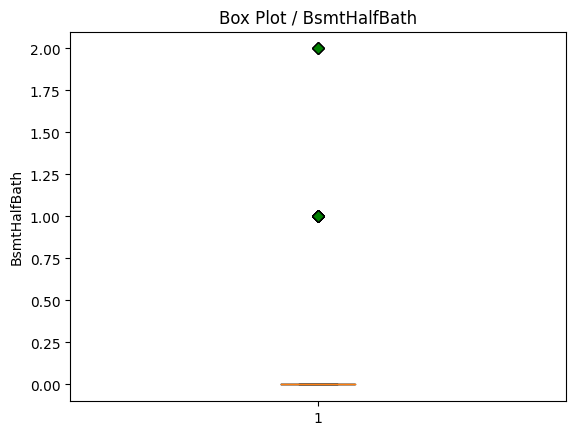

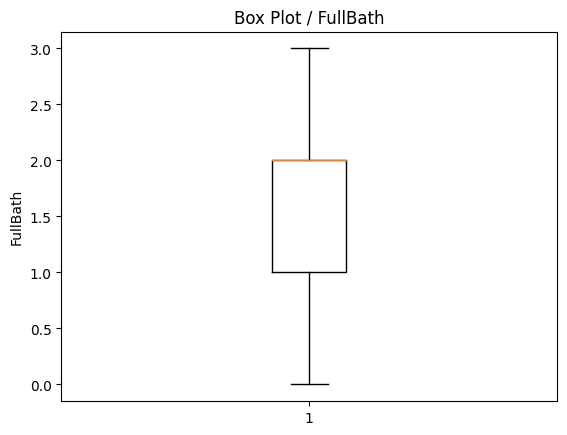

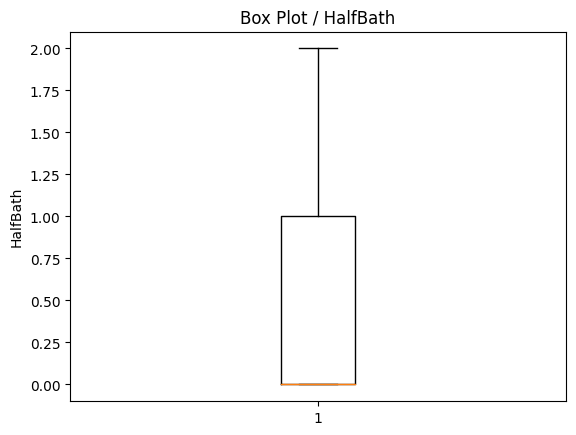

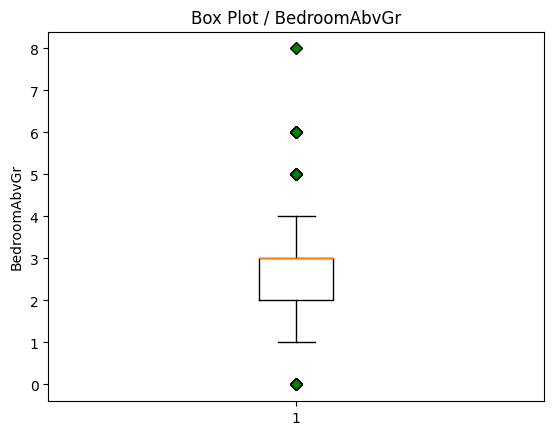

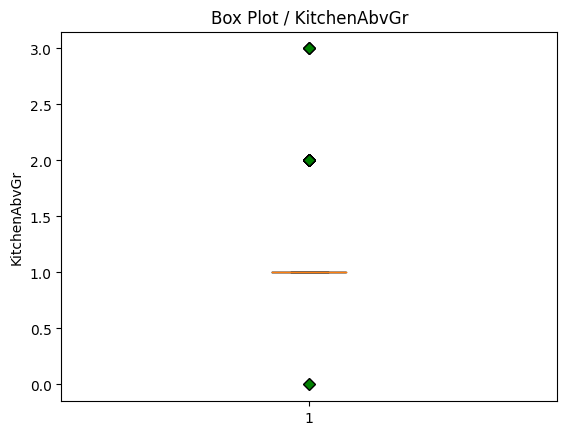

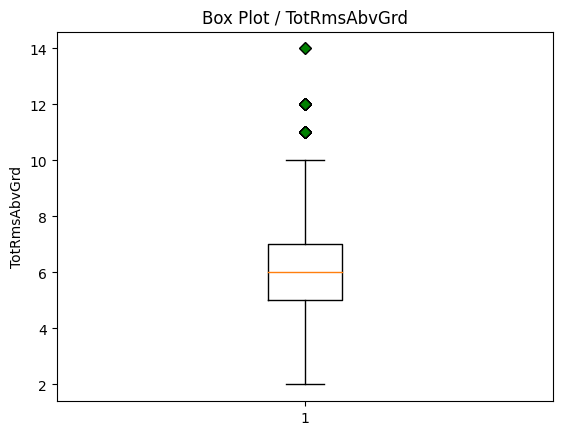

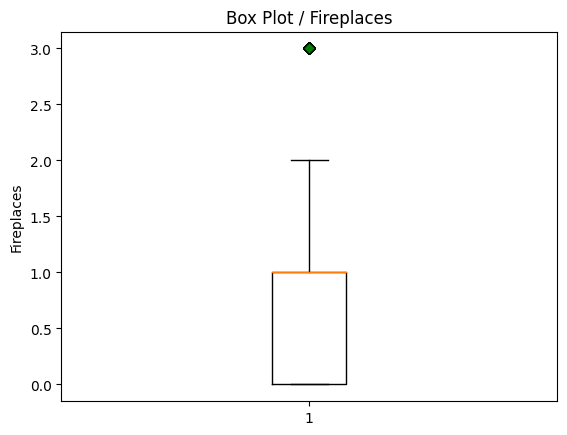

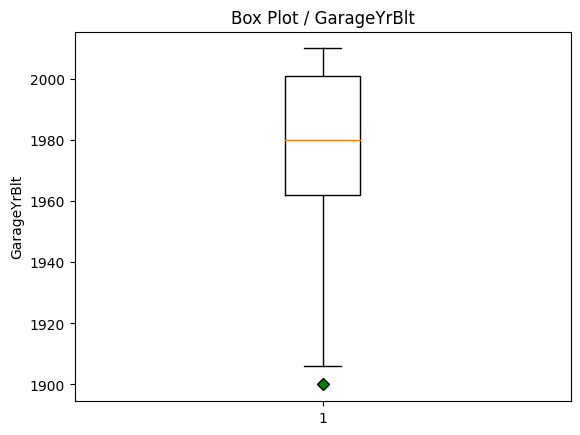

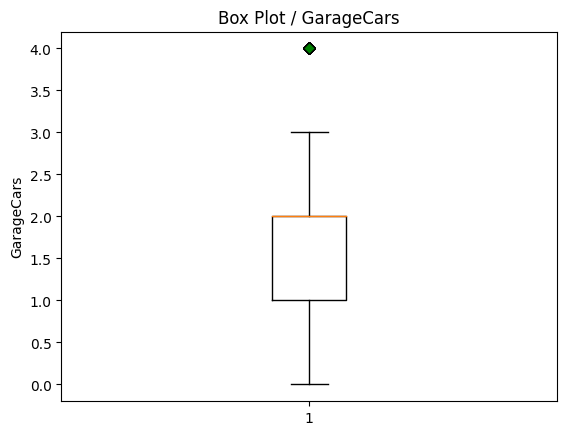

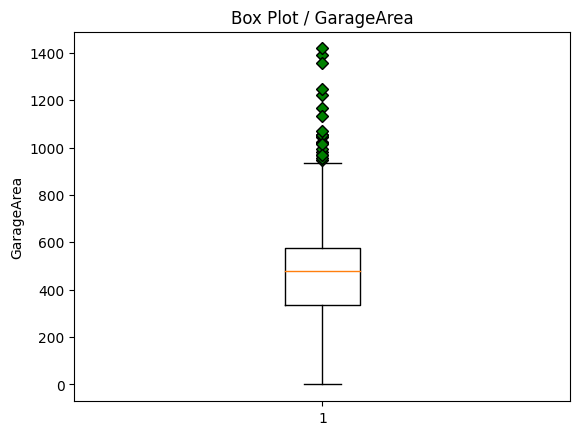

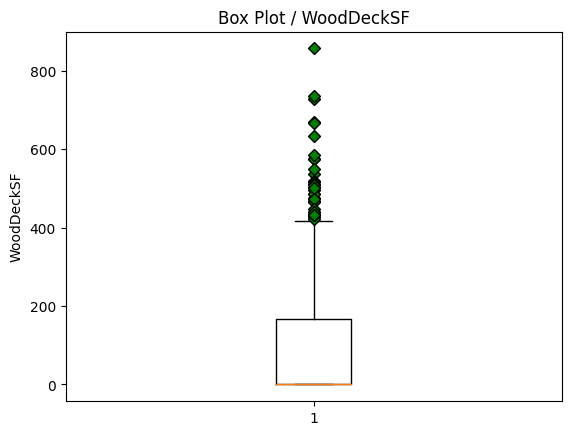

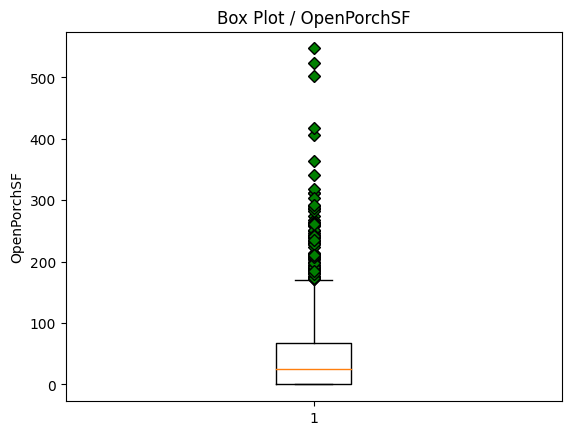

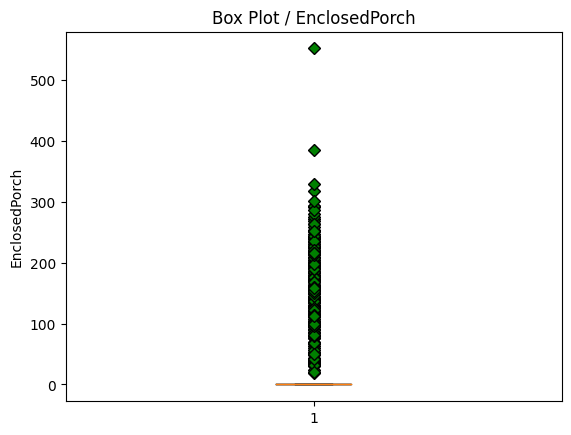

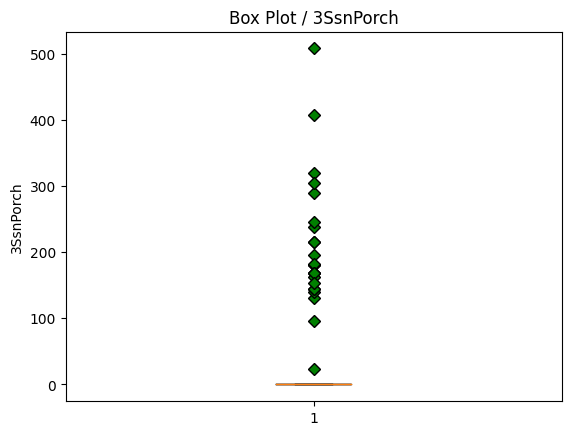

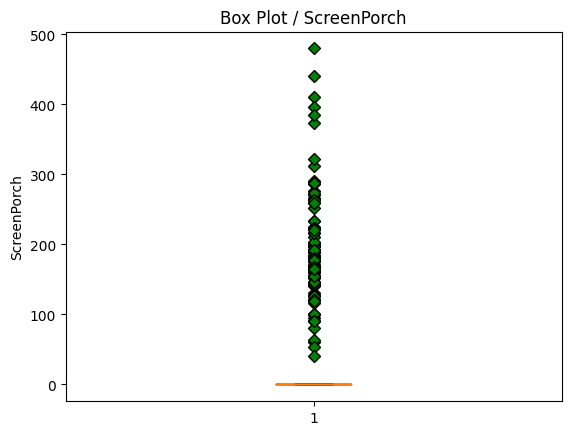

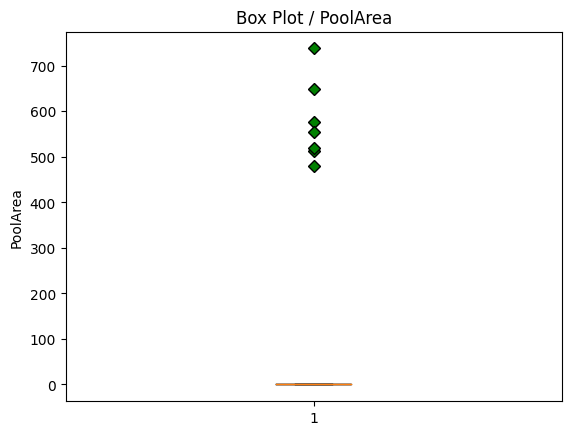

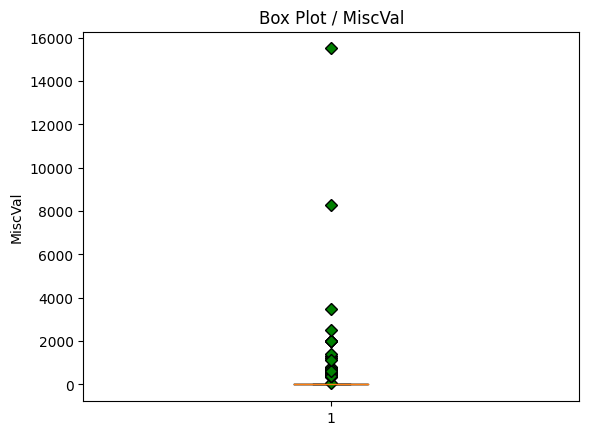

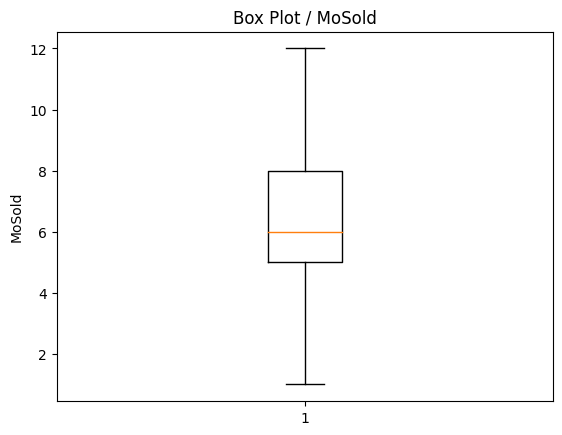

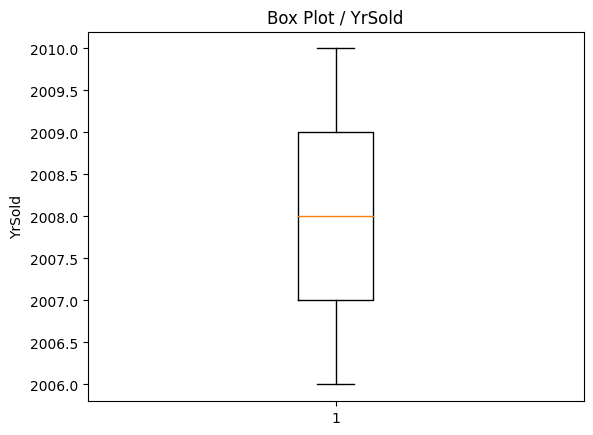

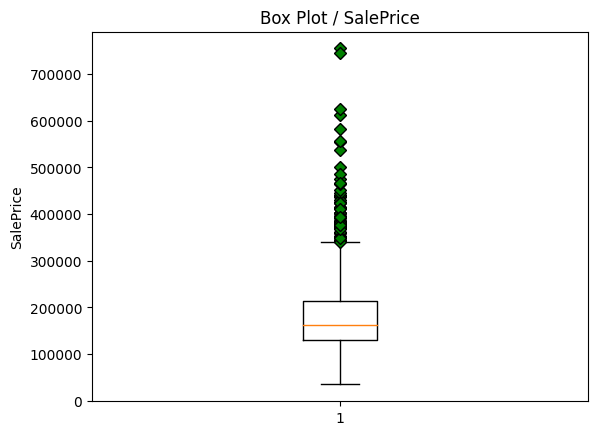

In [ ]:
#Para variables numéricas
green_diamond = dict(markerfacecolor='g', marker='D')
for i in numeric_columns:
  #fig = plt.figure(figsize =(7, 4))
  #plt.ylim(1, 100000000)
  plt.boxplot(df_train[i], flierprops=green_diamond)
  plt.title('Box Plot / ' + i)
  plt.ylabel(i)
  plt.show()

Vemos una presencia importante de outliers, para eliminarlos utilizaremos la medida de dispersión IQR.

In [ ]:
#Iterar sobre cada columna numérica
for column in numeric_columns:
    #Seleccionar la serie específica del DataFrame
    serie = df_train[column]

    #Calcular el IQR para la serie
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1

    #Identificar los bigotes
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_train = df_train[(serie >= lower_bound) & (serie <= upper_bound)]

Si queremos constantar los cambios realizados visualmente

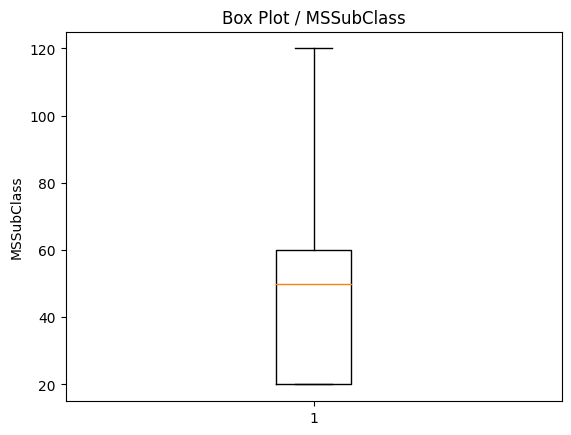

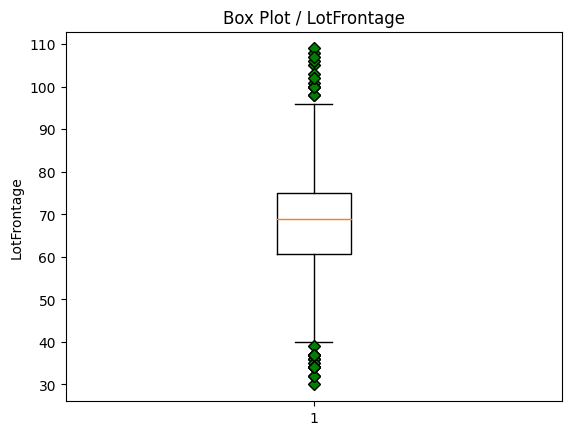

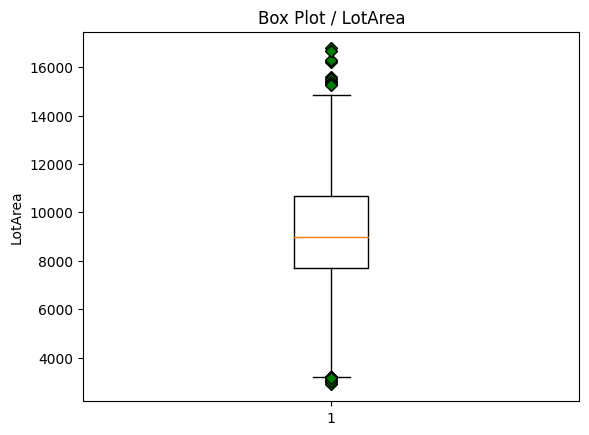

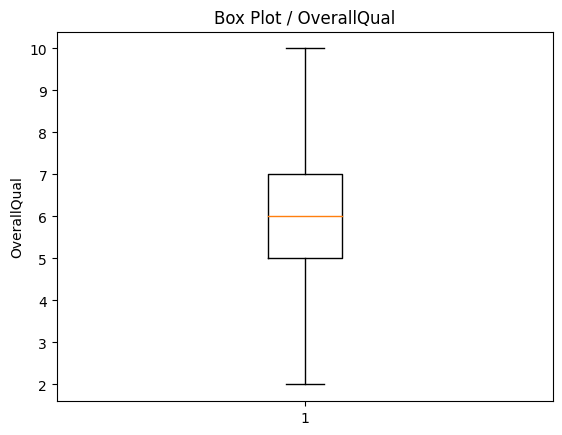

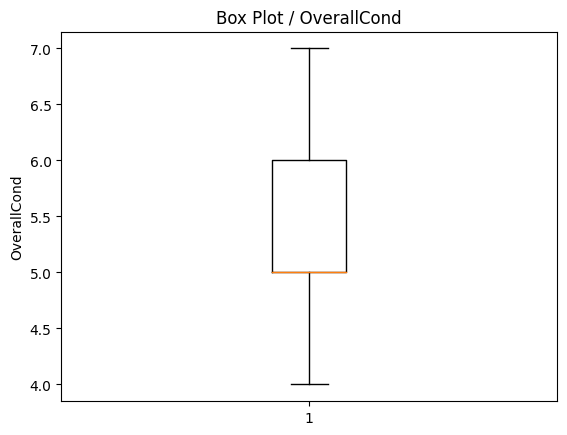

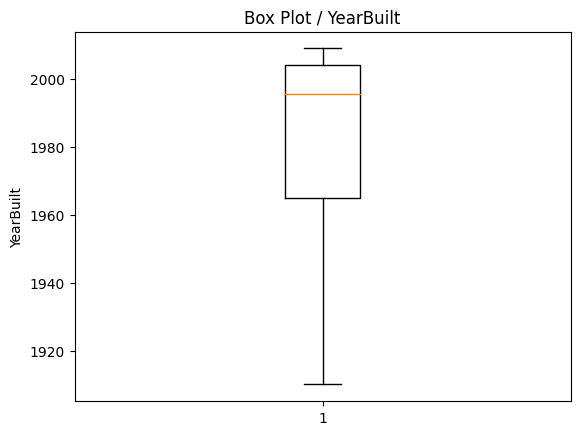

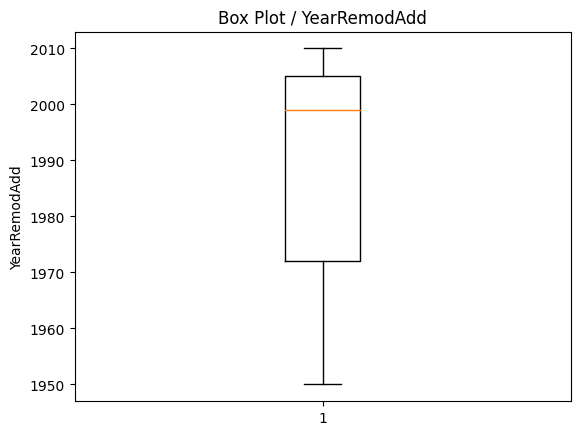

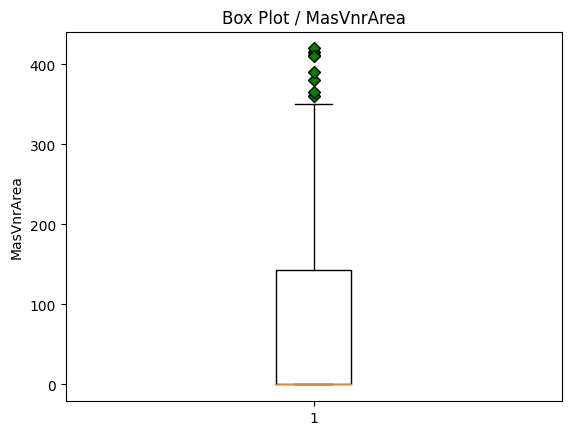

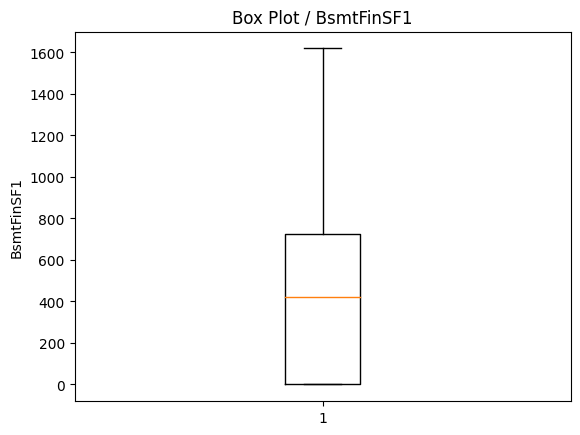

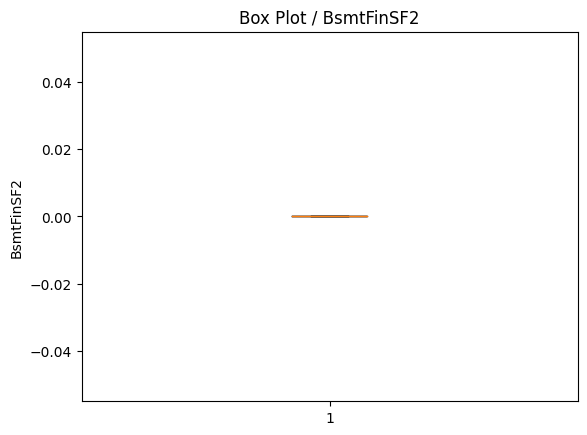

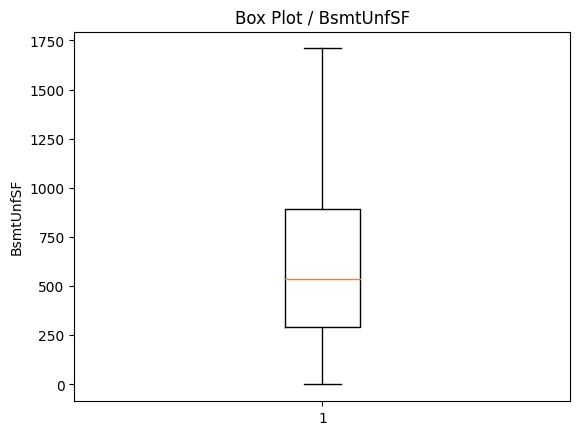

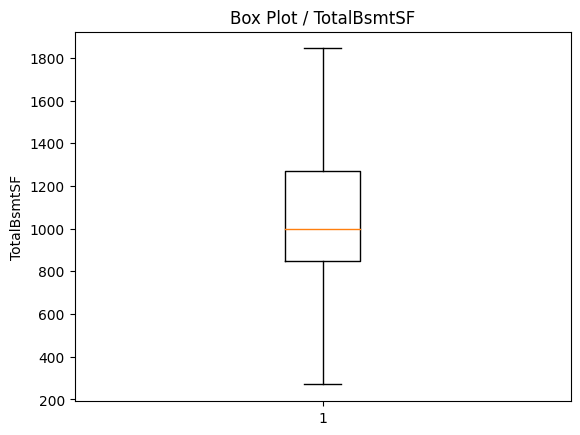

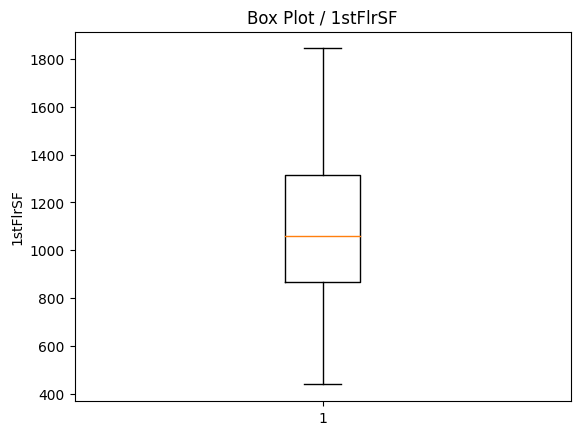

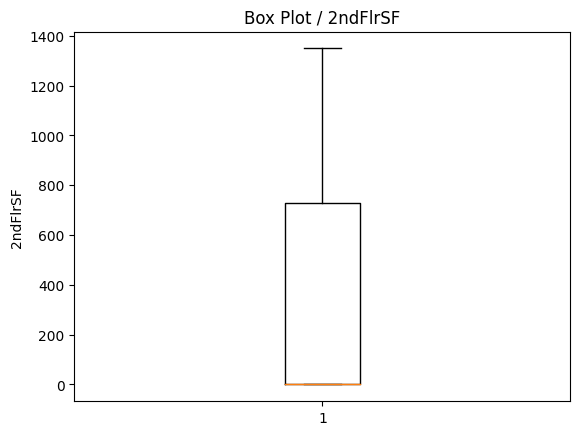

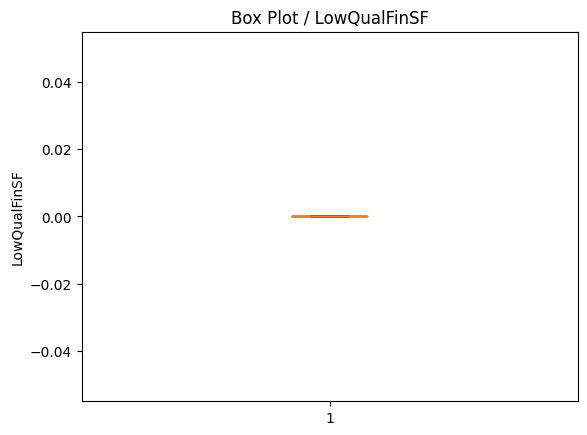

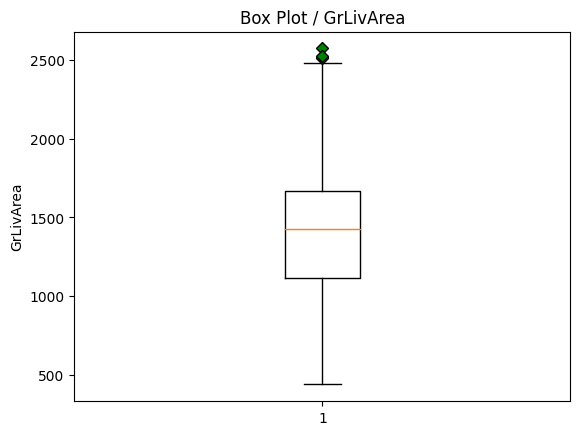

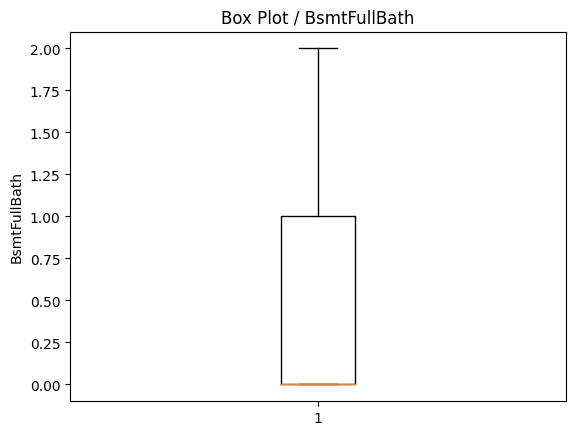

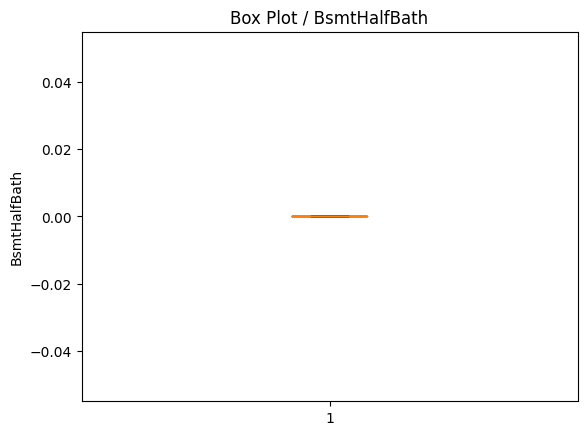

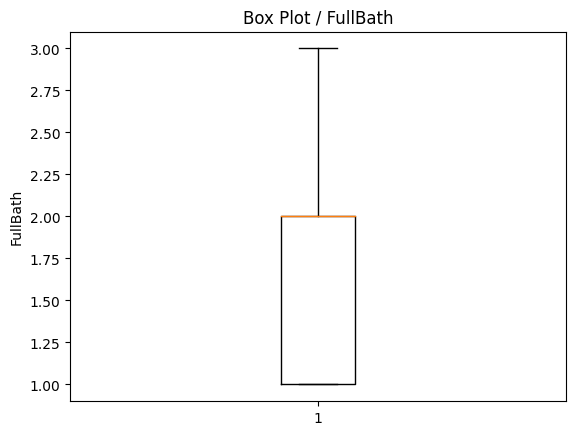

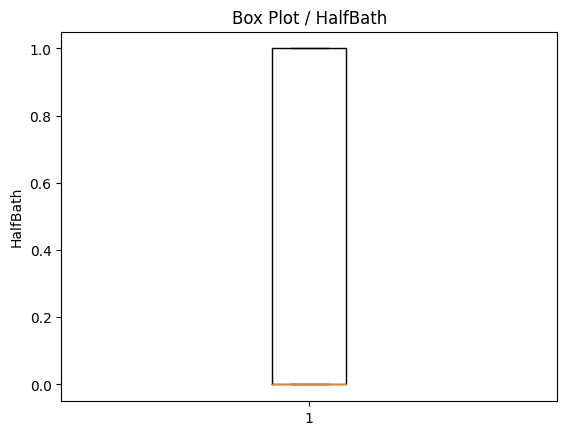

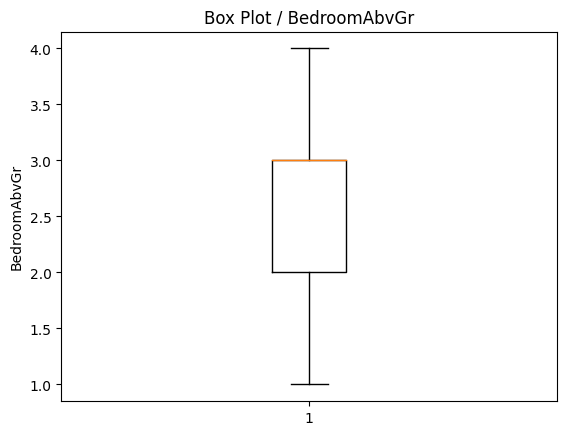

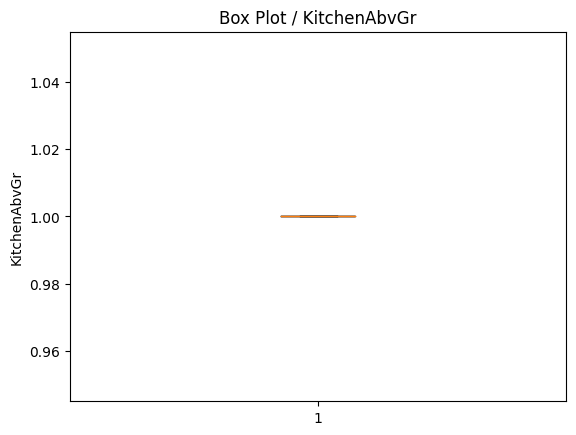

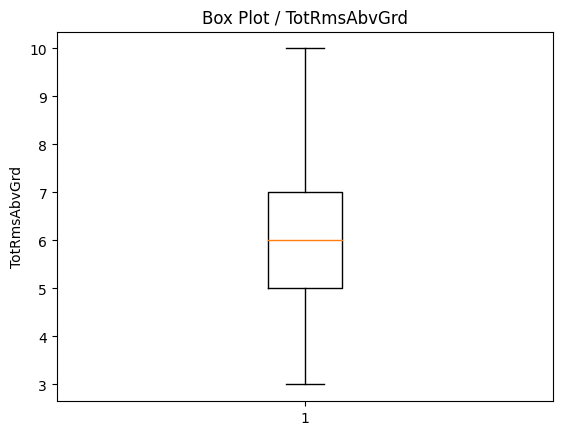

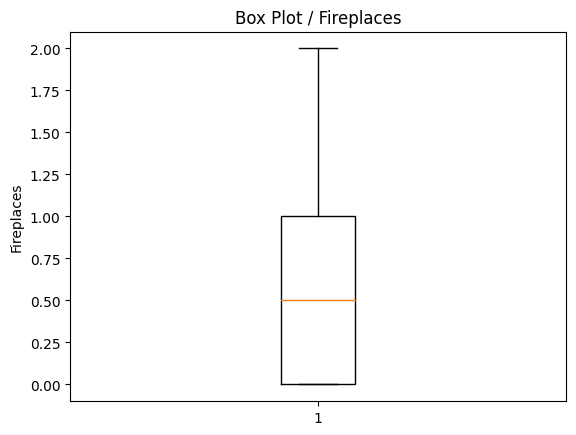

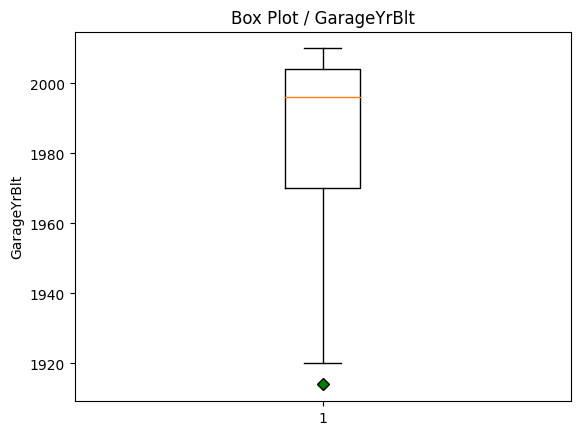

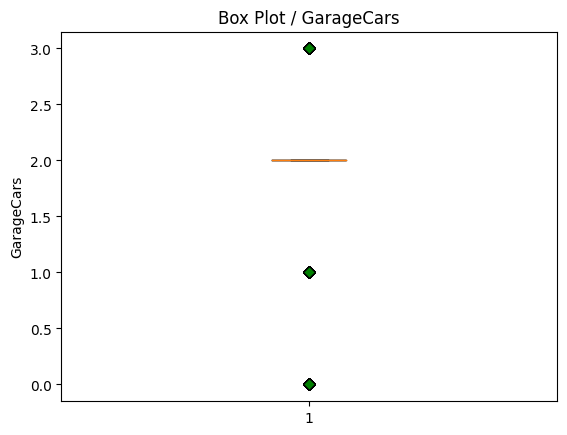

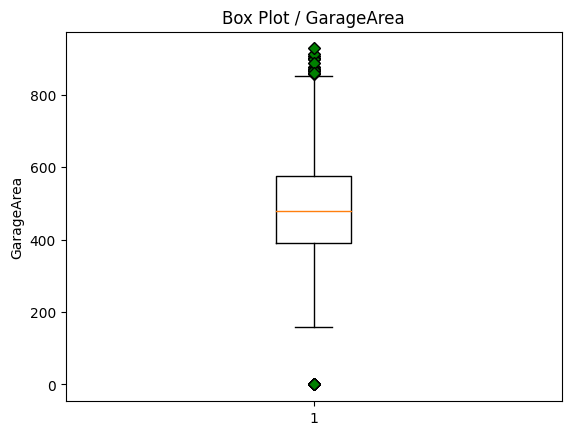

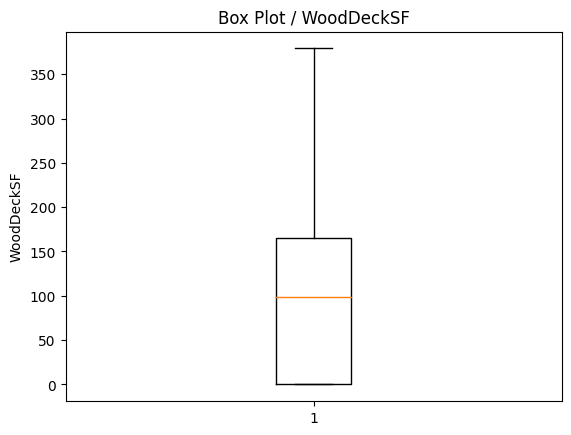

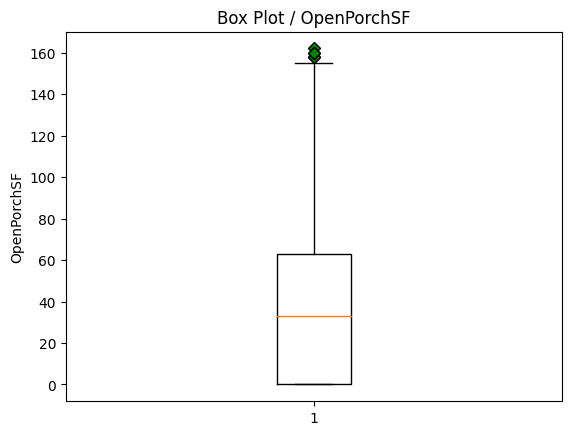

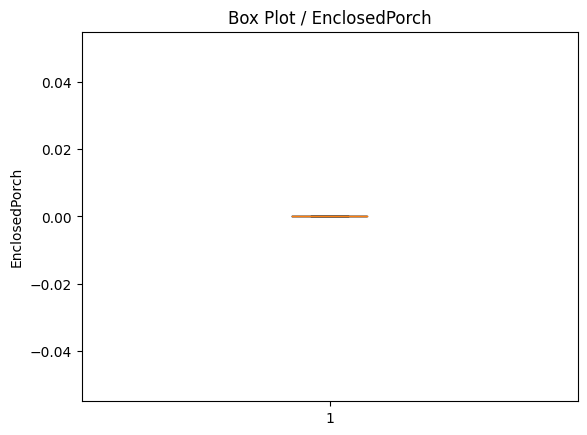

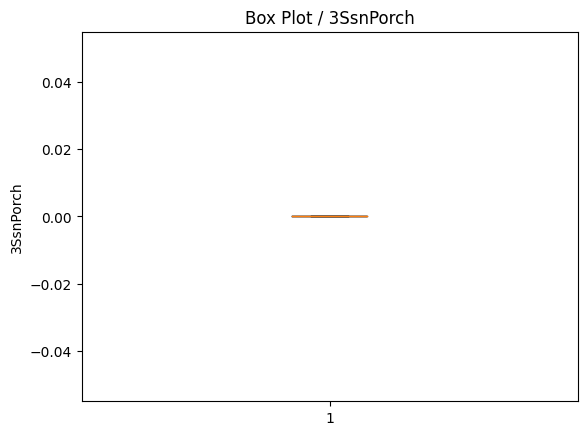

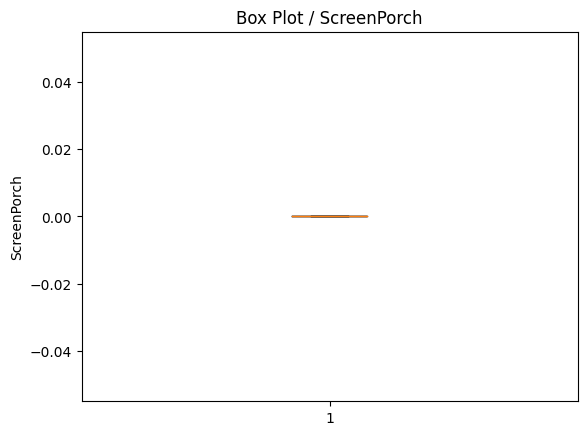

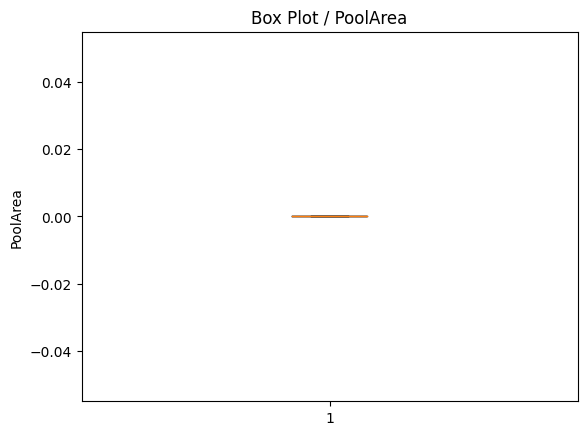

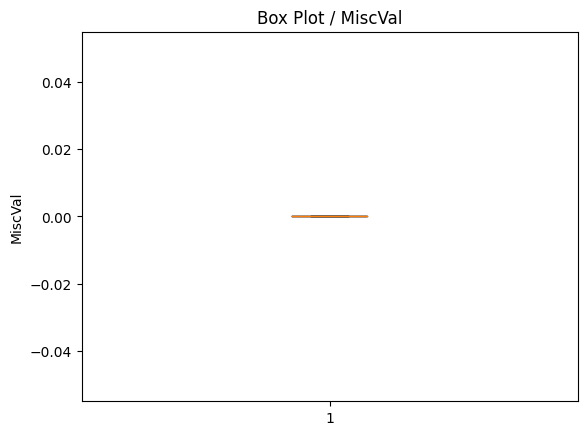

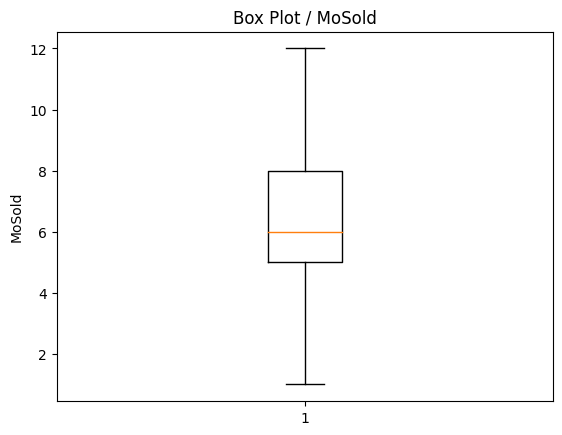

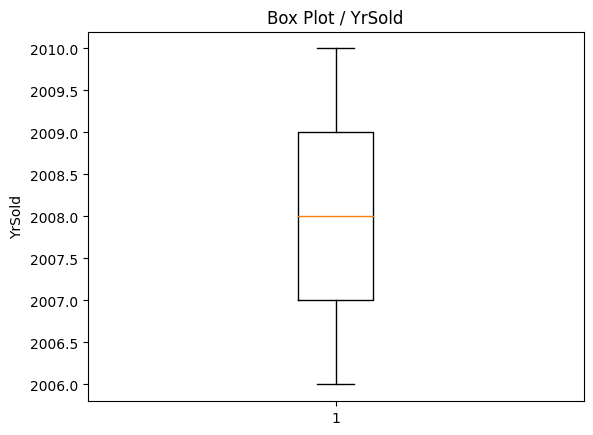

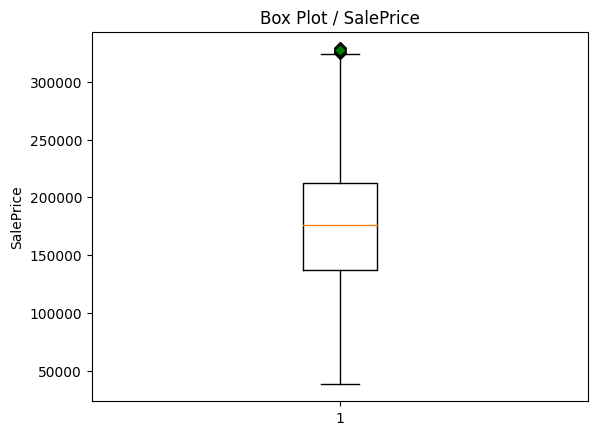

In [ ]:
#Para variables numéricas
green_diamond = dict(markerfacecolor='g', marker='D')
for i in numeric_columns:
  #fig = plt.figure(figsize =(7, 4))
  #plt.ylim(1, 100000000)
  plt.boxplot(df_train[i], flierprops=green_diamond)
  plt.title('Box Plot / ' + i)
  plt.ylabel(i)
  plt.show()

Haciendo un análisis de correlaciones, por último

Text(0.5, 1.0, 'Matriz de Correlaciones numericas')

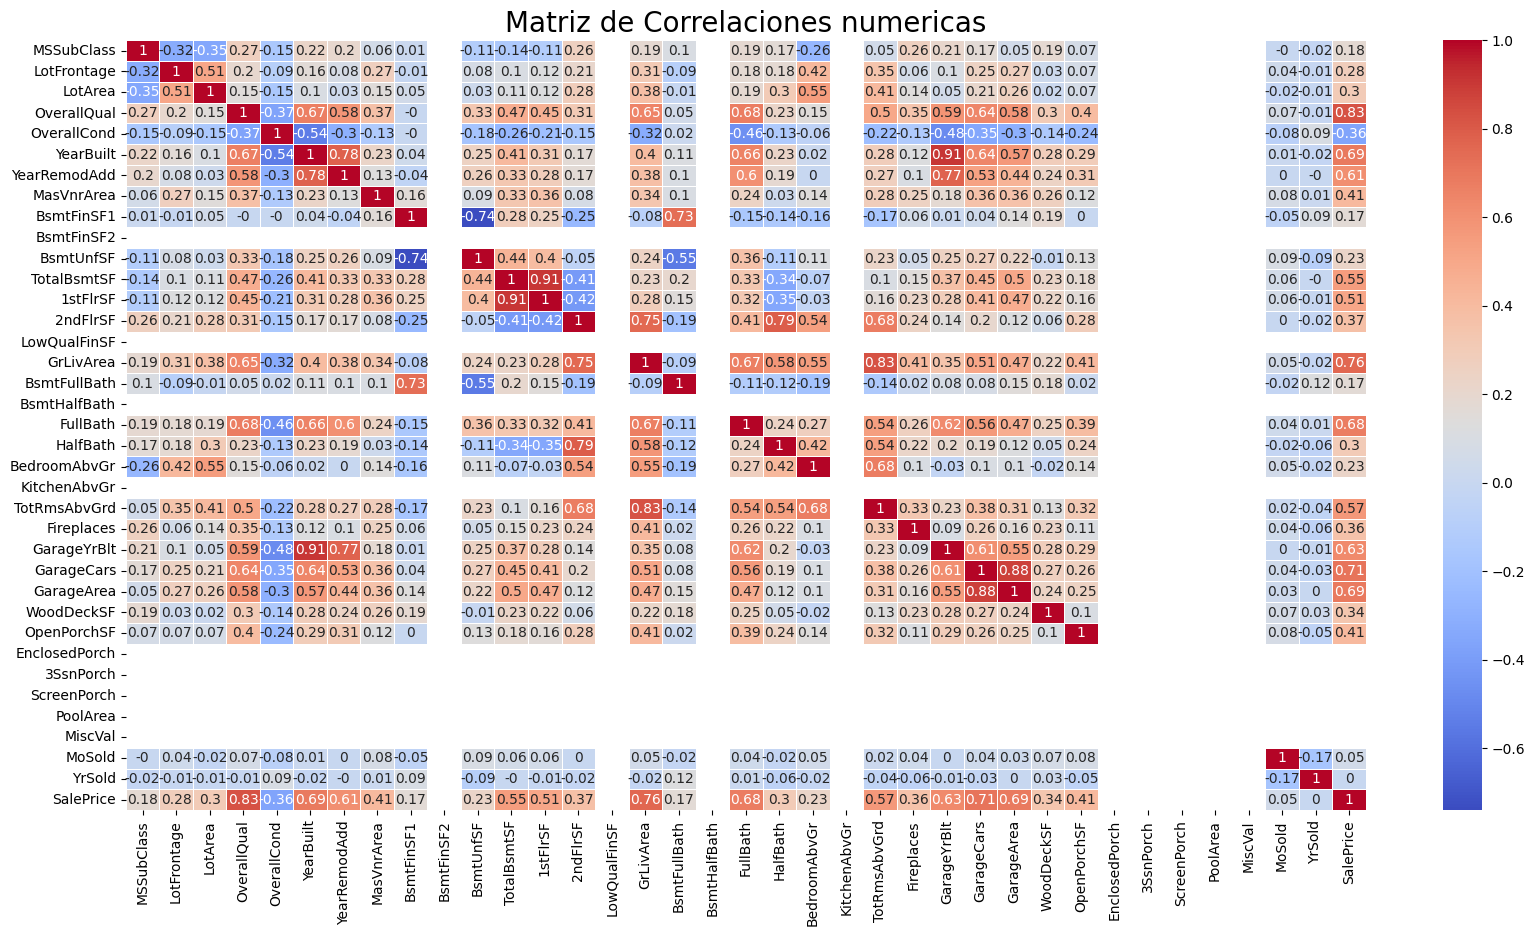

In [ ]:
#Correlaciones
plt.figure(figsize=(20, 10))
correlation_matrix = df_train[numeric_columns].corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Matriz de Correlaciones numericas", size=20)

Asumiendo en cuanto a las relaciones lo siguientes umbrales
* 0.00 - 0.19: Muy débil
* 0.20 - 0.39: Débil
* 0.40 - 0.59: Moderada
* 0.60 - 0.79: Fuerte
* 0.80 - 1.00: Muy fuerte

Por lo tanto, escogeré variables de 0.6 hacia arriba entre las que tenemos:

* OverallQual: 0.83
* YearBuilt: 0.69
* YearRemodAdd: 0.61
* GrLivArea: 0.76
* FullBath: 0.68
* GarageYrBlt: 0.63
* GarageCars: 0.71
* GarageArea: 0.69

Inicialmente esas eran las variables que decidí usar, sin embargo, probando con mas variables en el umbral de 0.40 a a 0.59 me ayudó a mejorar ligeramente el modelo

También podemos apreciar como al tratar outliers algunas variables se han visto afectadas, lo que quiere decir que eran muy sensibles y con una alta varianza.


In [ ]:
#Dropear columnas con baja correlación
#set_numeric_columns = ['OverallQual','YearBuilt','YearRemodAdd','GrLivArea','FullBath','GarageYrBlt','GarageCars','GarageArea']
set_numeric_columns = ['OverallQual','YearBuilt','YearRemodAdd','GrLivArea','FullBath',
                       'GarageYrBlt','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','TotRmsAbvGrd','MasVnrArea']
numeric_columns = list(set(numeric_columns).intersection(set_numeric_columns))

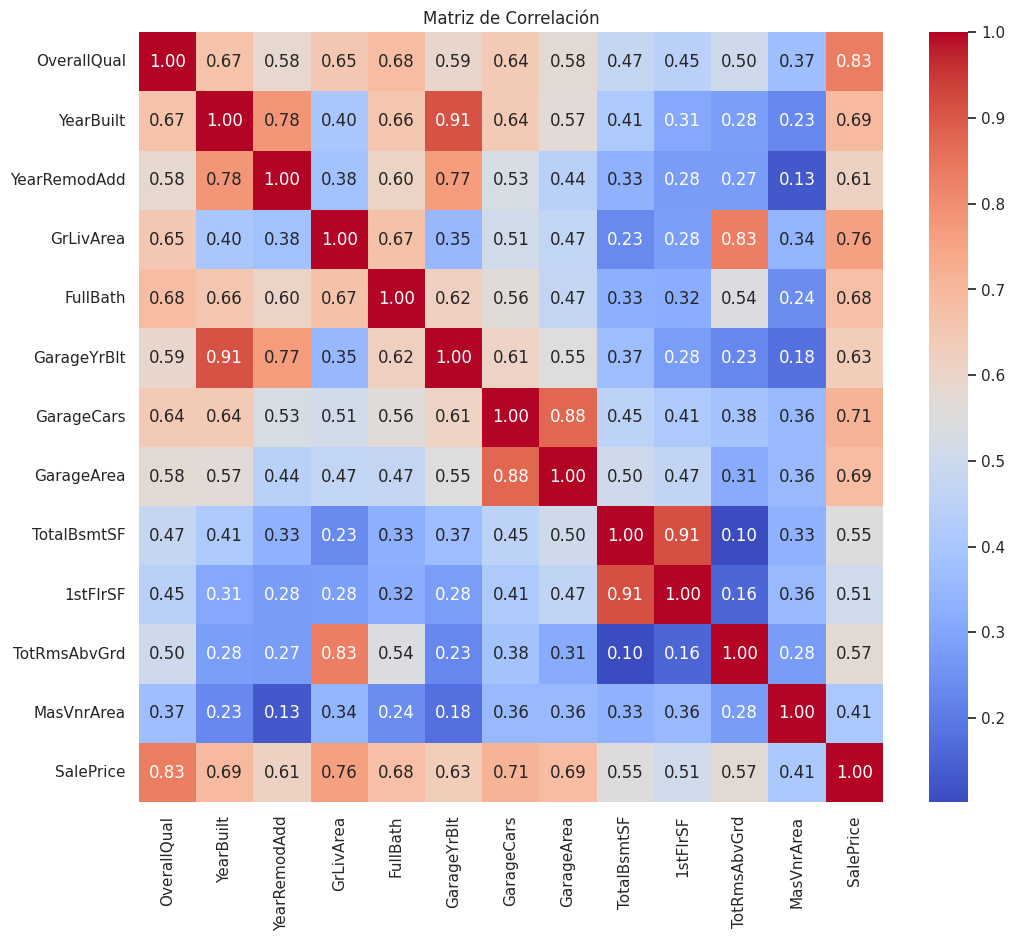

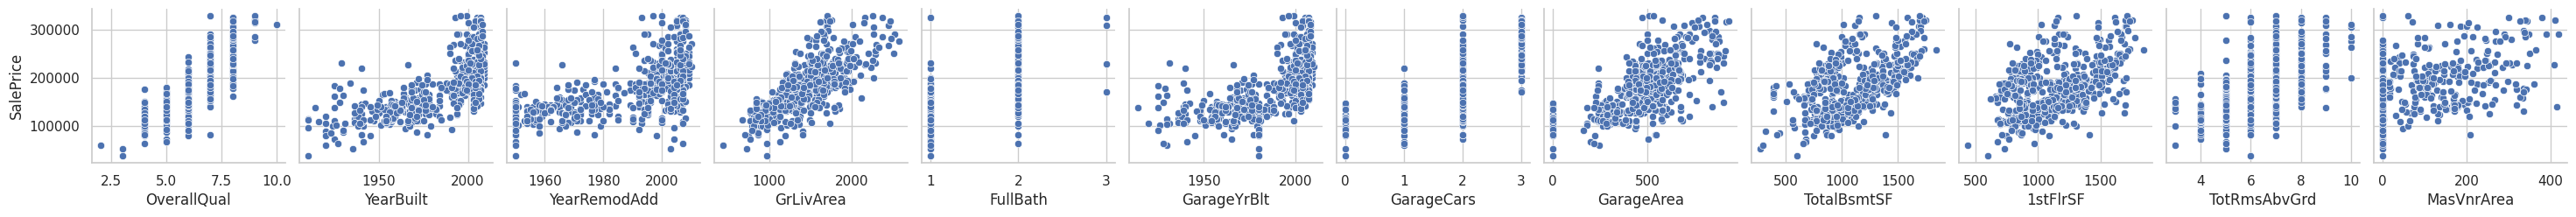

In [ ]:
# Añade la variable objetivo 'SalePrice'
set_numeric_columns.append('SalePrice')
# Crea un DataFrame con las columnas seleccionadas
df_numeric = df_train[set_numeric_columns]
# Calcula la matriz de correlación
corr_matrix = df_numeric.corr()
# Configura el estilo del gráfico
sns.set(style='whitegrid')
# Configura el tamaño de la figura
plt.figure(figsize=(12, 10))
# Crea un mapa de calor de la matriz de correlación
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# Configura el título del gráfico
plt.title('Matriz de Correlación')
# Muestra el gráfico
plt.show()
# Crea gráficos de dispersión para pares de variables seleccionadas contra 'SalePrice'
sns.pairplot(df_numeric, x_vars=set_numeric_columns[:-1], y_vars=['SalePrice'])
plt.show()

In [ ]:
#Columnas seleccionadas finalmente para ser mantenindas en el dataframe
numeric_columns = numeric_columns + ["SalePrice"]

###**Analizando las variables categoricas**

In [ ]:
categorical_columns

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [ ]:
#Cantidad de Variables categóricas
print("La cantidad de caracteristicas categóricas es de:", len(categorical_columns))

La cantidad de caracteristicas categóricas es de: 43


In [ ]:
#Revisando caracteristicas
total_rows = len(df_train)
for column in df_train.columns:
    print(f"Conteo de Valores por columna '{column}':")
    counts = df_train[column].value_counts()
    percentages = df_train[column].value_counts(normalize=True) * 100
    combined = pd.concat([counts, percentages], axis=1)
    combined.columns = ['Conteo', 'Porcentaje (%)']
    print(combined)
    print("\n")

Conteo de Valores por columna 'MSSubClass':
     Conteo  Porcentaje (%)
20      232       42.335766
60      153       27.919708
120      55       10.036496
50       35        6.386861
80       24        4.379562
30       20        3.649635
85       11        2.007299
70       10        1.824818
90        5        0.912409
45        3        0.547445


Conteo de Valores por columna 'MSZoning':
    Conteo  Porcentaje (%)
RL     474       86.496350
RM      44        8.029197
FV      27        4.927007
RH       3        0.547445


Conteo de Valores por columna 'LotFrontage':
       Conteo  Porcentaje (%)
69.0      109       19.890511
60.0       41        7.481752
70.0       30        5.474453
65.0       27        4.927007
80.0       24        4.379562
...       ...             ...
30.0        1        0.182482
94.0        1        0.182482
47.0        1        0.182482
108.0       1        0.182482
49.0        1        0.182482

[71 rows x 2 columns]


Conteo de Valores por columna 'LotAre

Identificando aquellas categorías que puedan ser irrelevante debido a varianza tendiente a 0, que por lo tanto no aportarán a la predicción buscada, lo que conllevará en que sean eliminadas del dataframe

In [ ]:
#Identificando categorias únicas
columns_to_drop = []
for column in categorical_columns:
  if len(df_train[column].unique()) == 1:
    print(f"La categória '{column}' tiene solo una etiqueta.")
    #Almacenar la columna en la lista
    columns_to_drop.append(column)

La categória 'Utilities' tiene solo una etiqueta.
La categória 'Condition2' tiene solo una etiqueta.
La categória 'RoofMatl' tiene solo una etiqueta.
La categória 'BsmtFinType2' tiene solo una etiqueta.
La categória 'PoolQC' tiene solo una etiqueta.


In [ ]:
#Columnas a eliminar según análisis previo
columns_to_drop

['Utilities', 'Condition2', 'RoofMatl', 'BsmtFinType2', 'PoolQC']

In [ ]:
#Dropear columnas categoricas identificadas anteriormente
categorical_columns = [elemento for elemento in categorical_columns if elemento not in columns_to_drop]

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


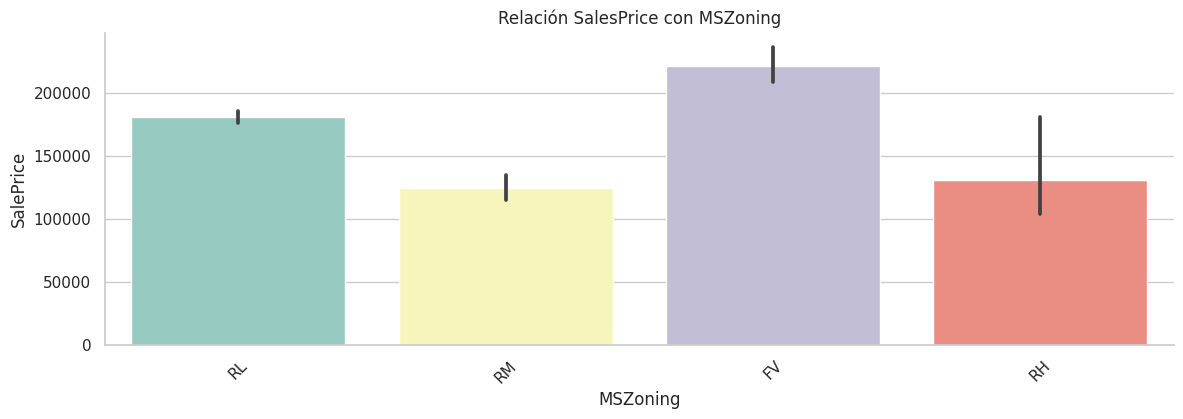

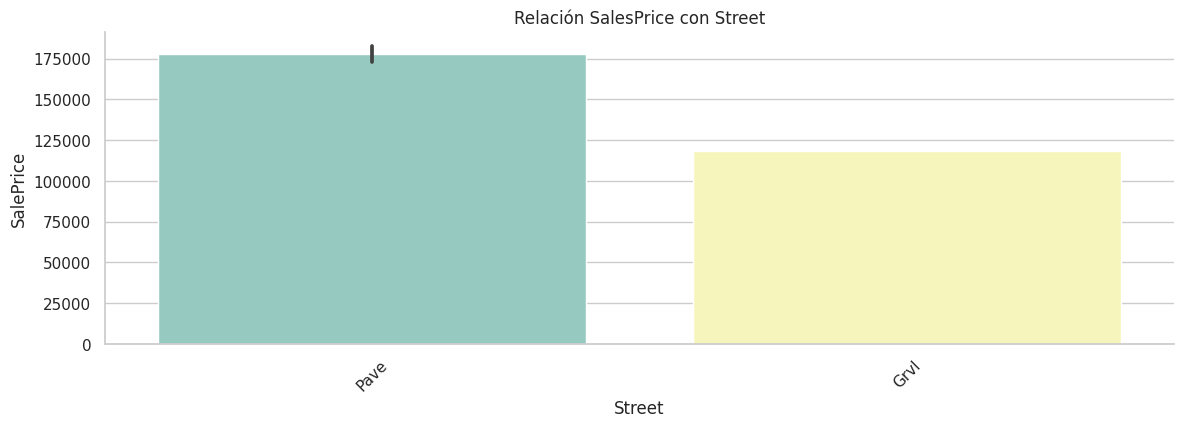

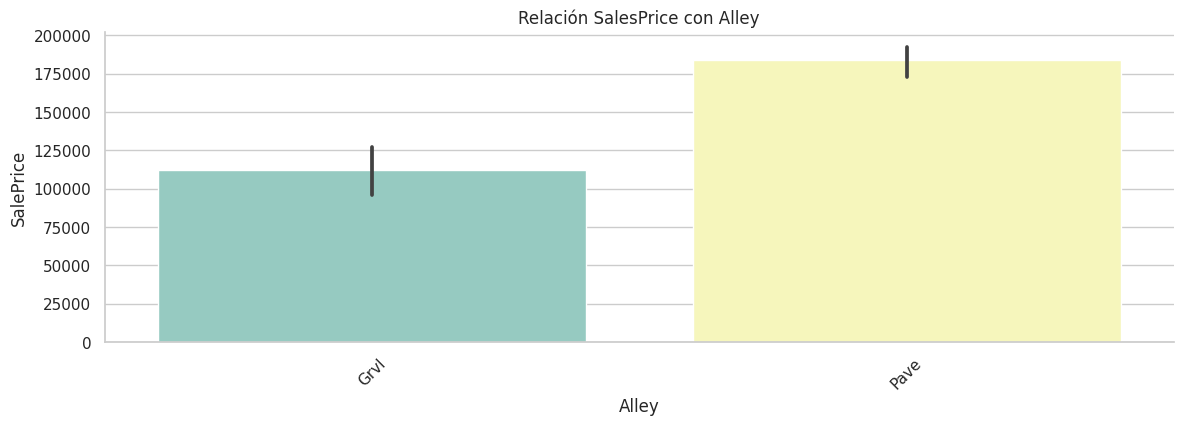

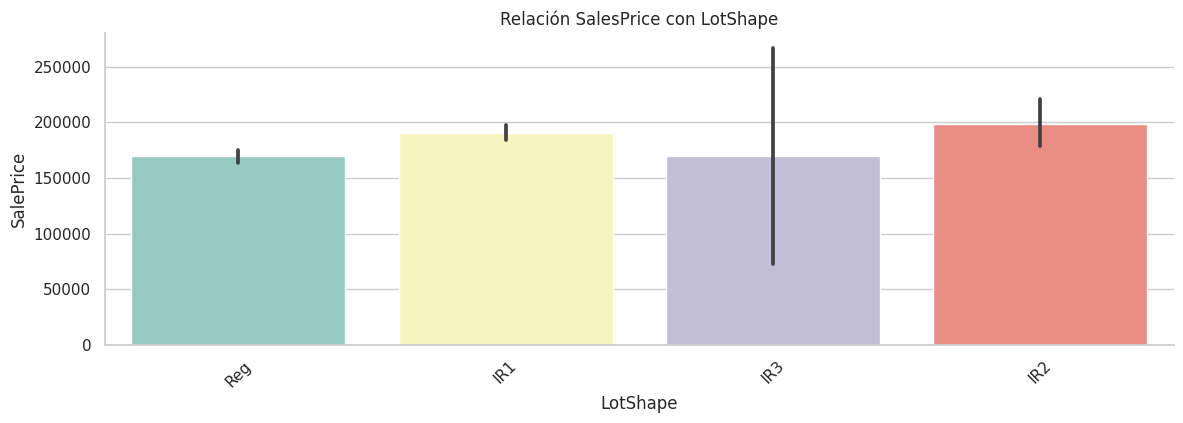

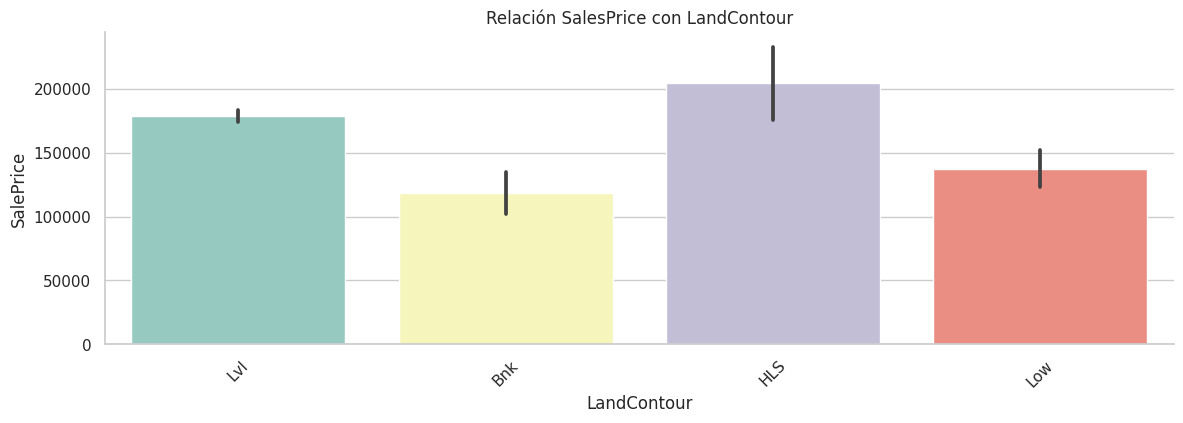

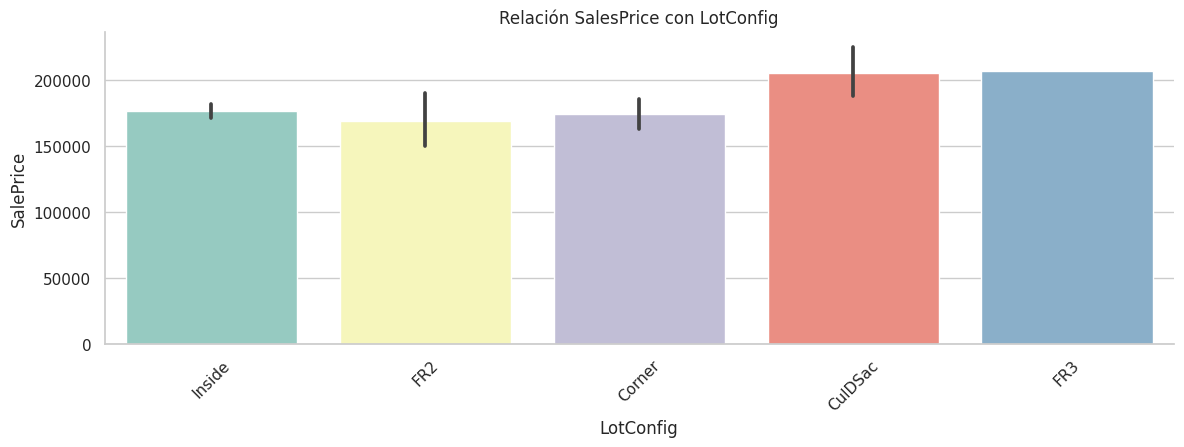

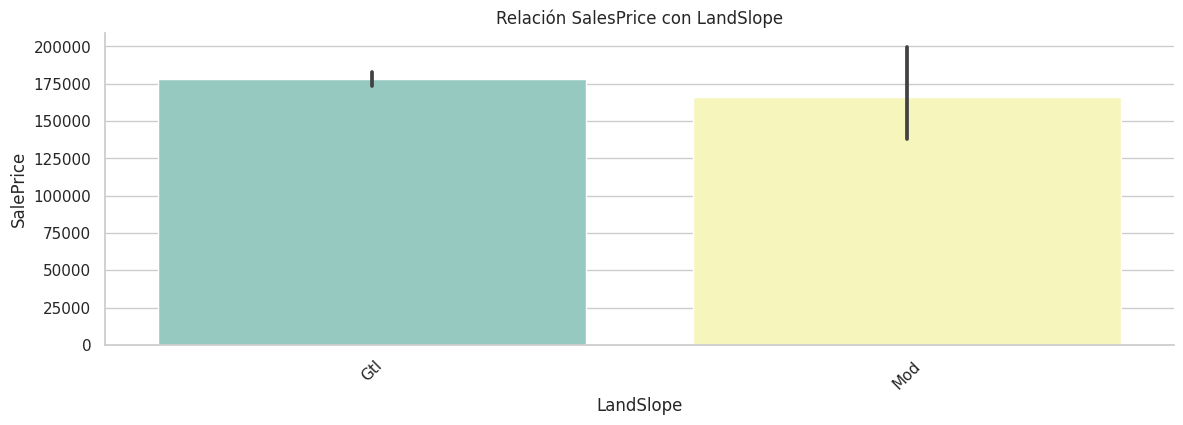

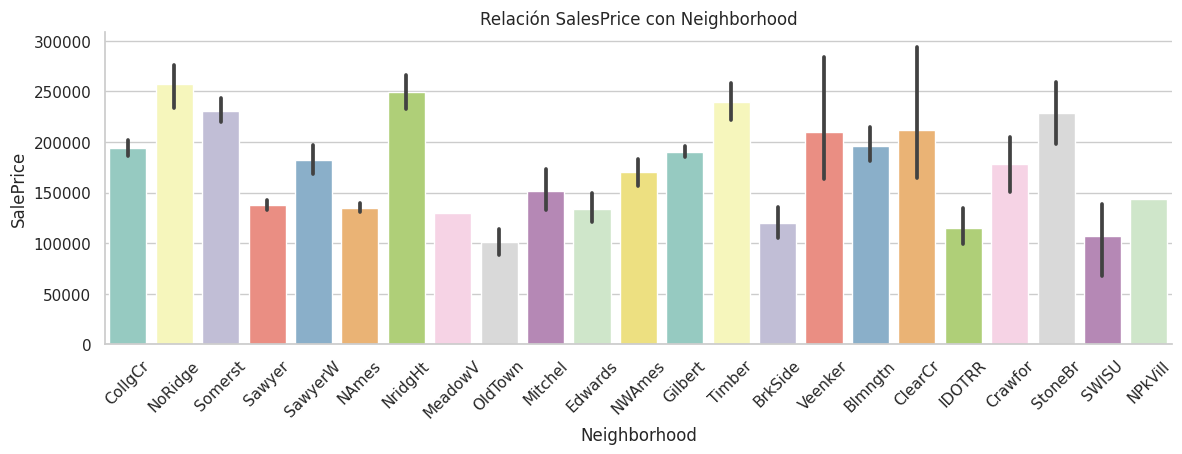

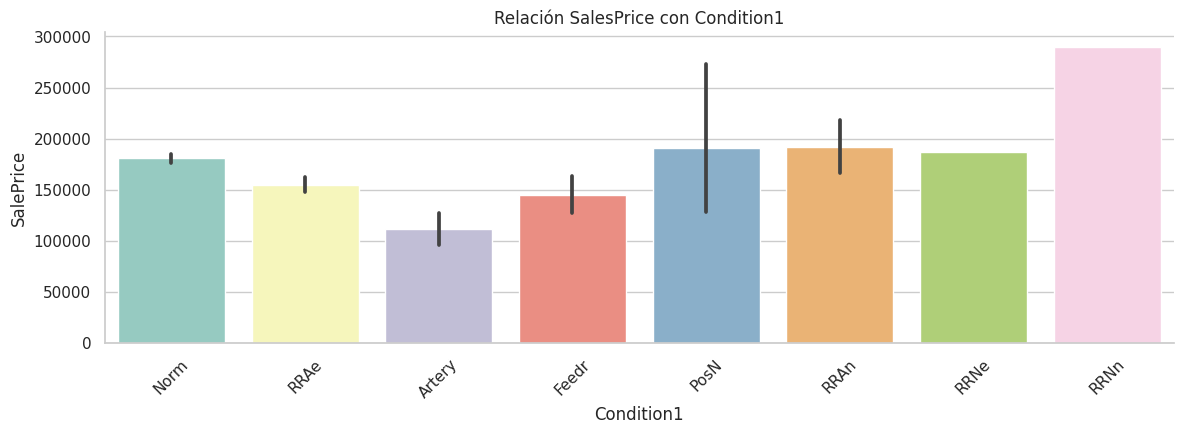

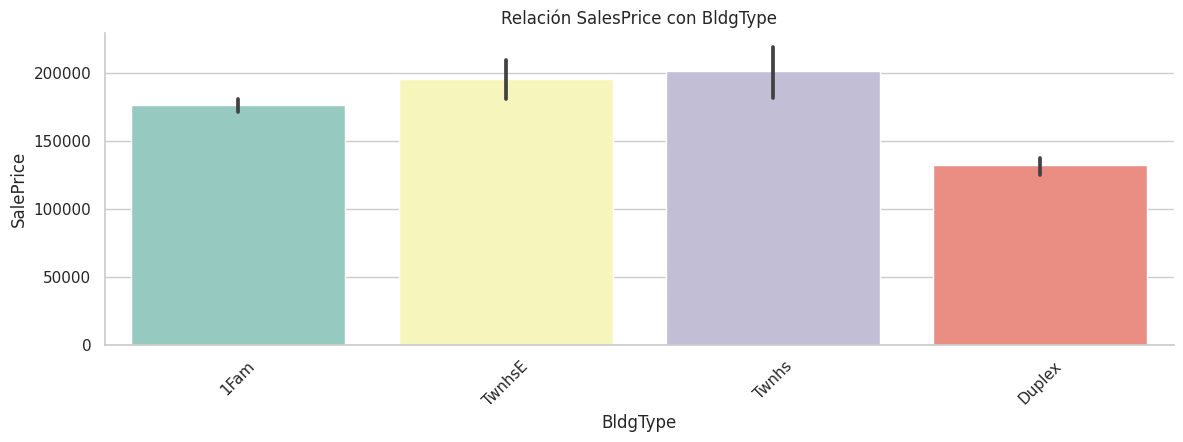

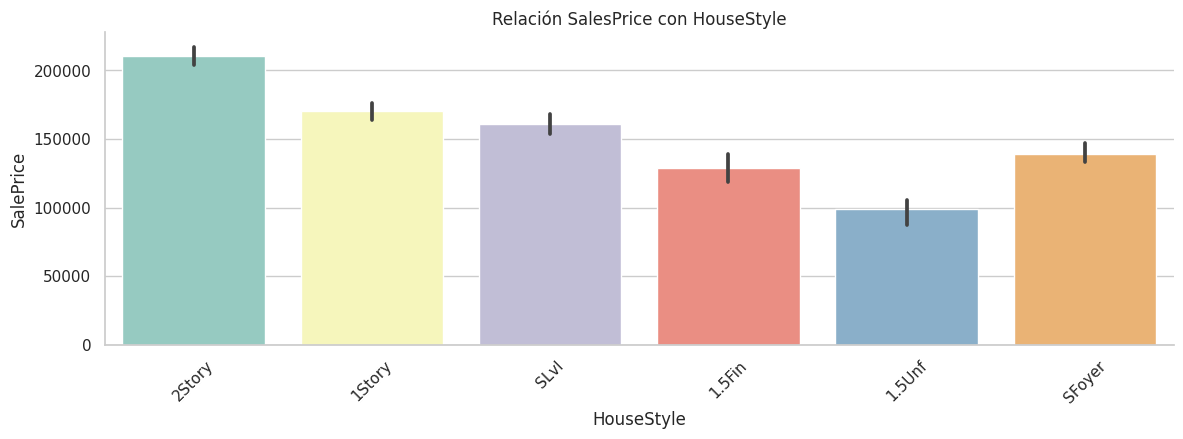

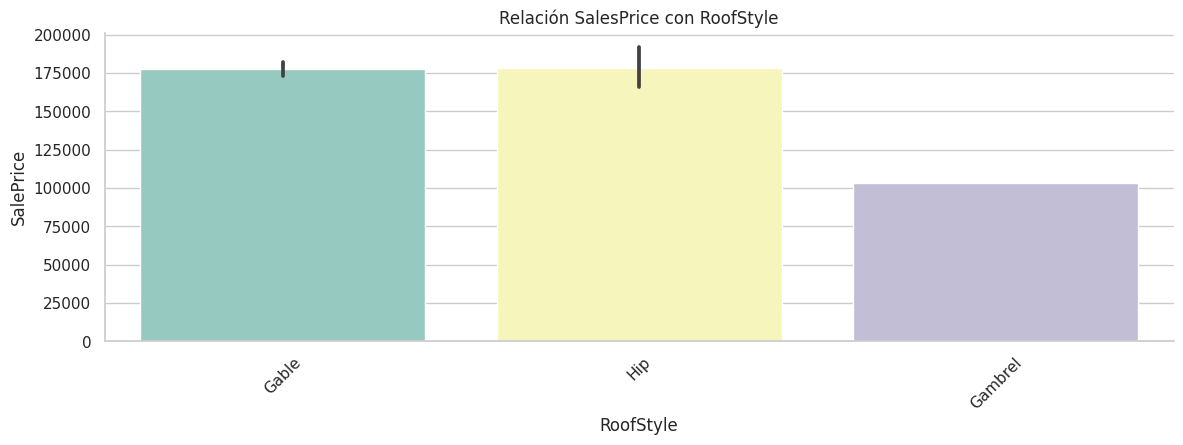

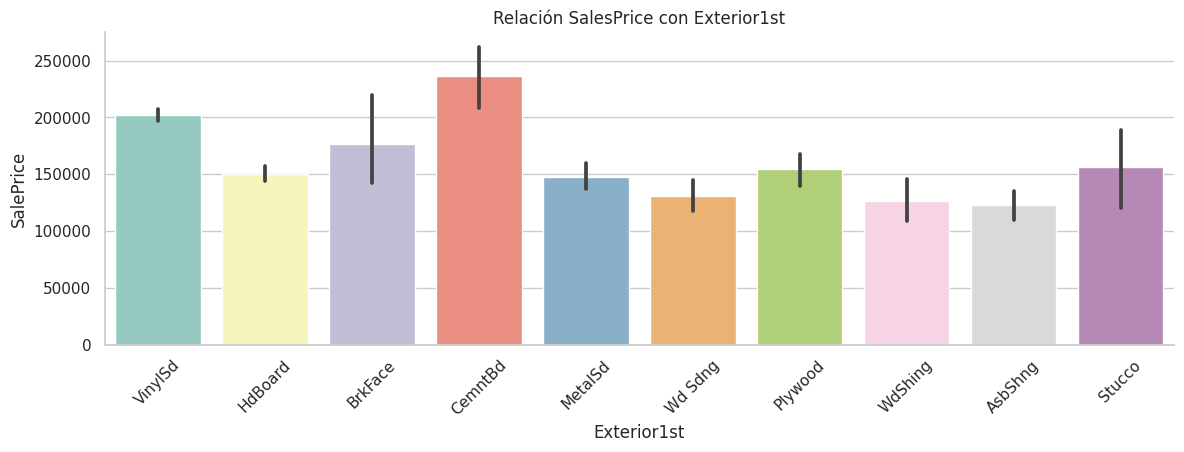

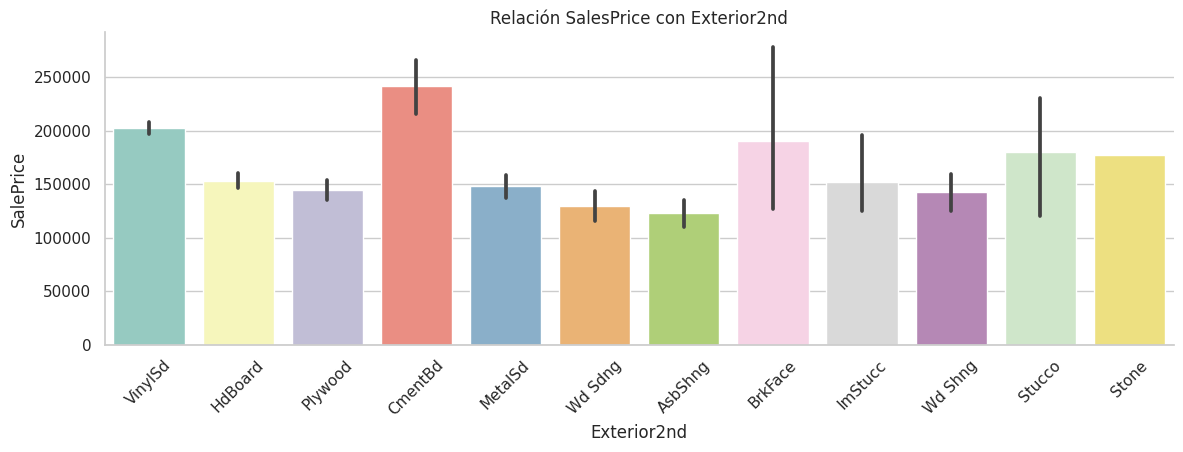

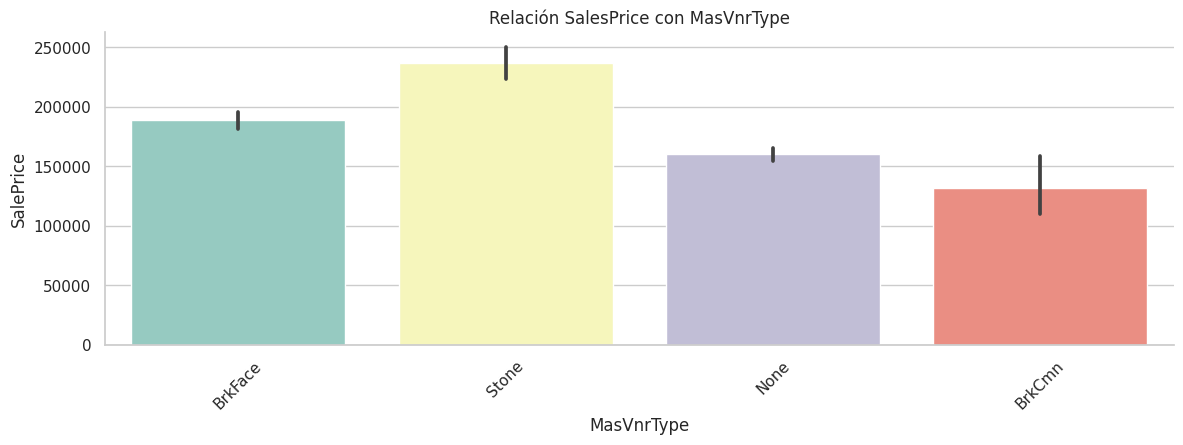

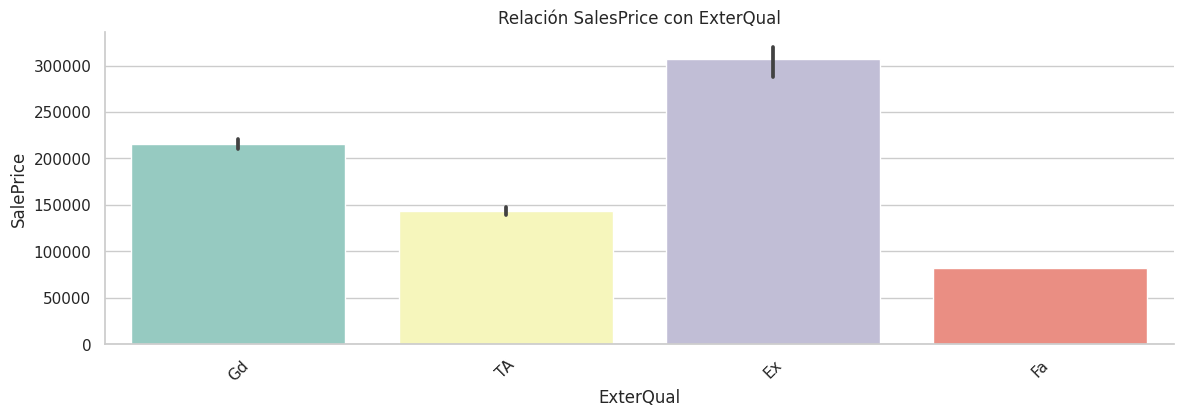

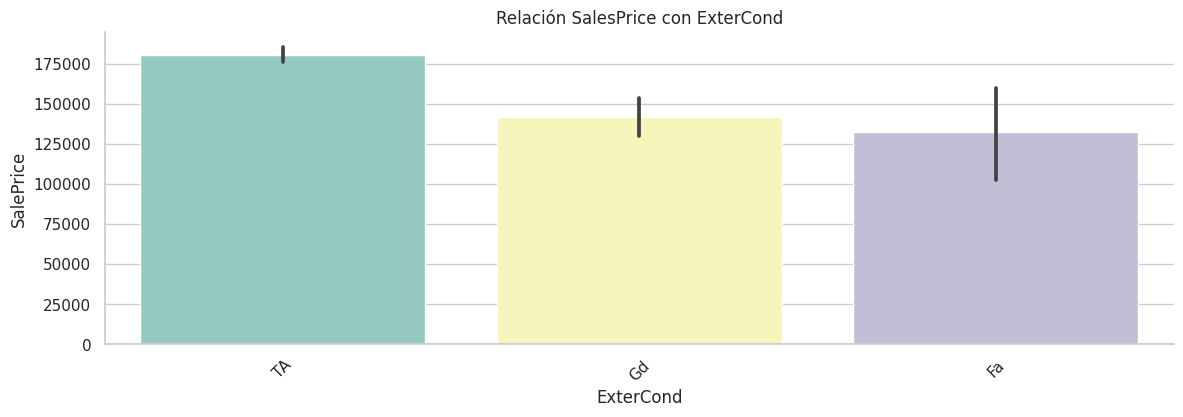

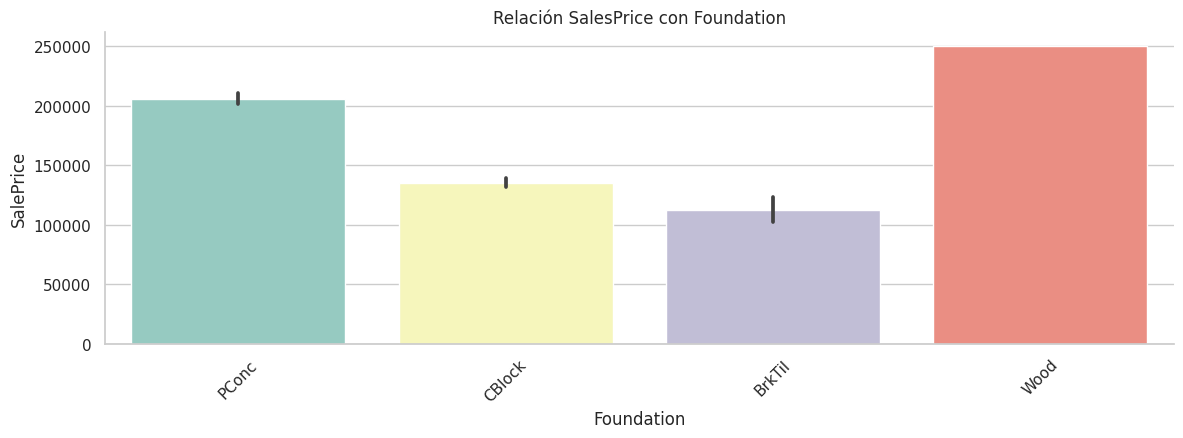

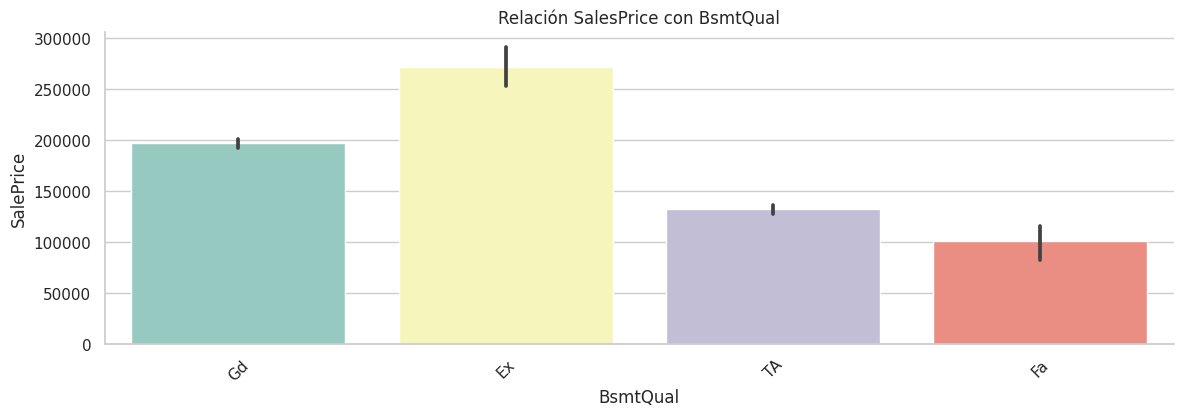

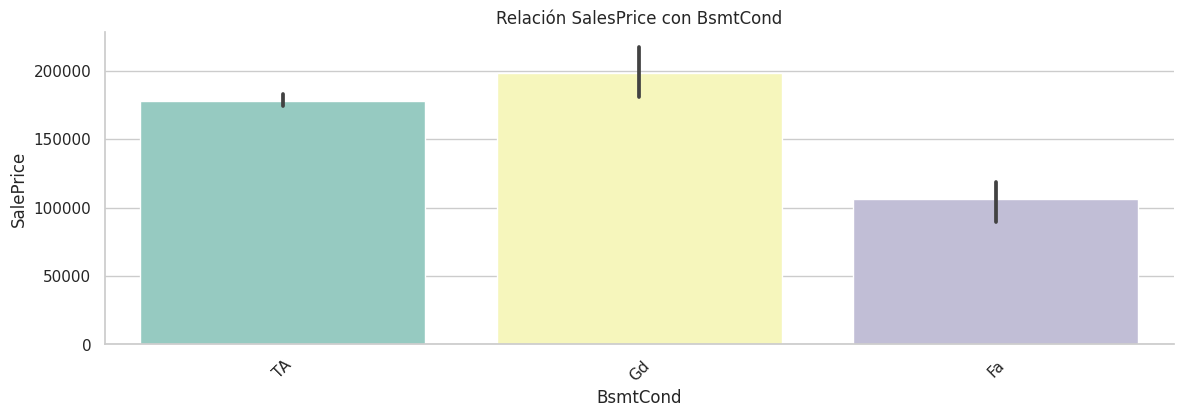

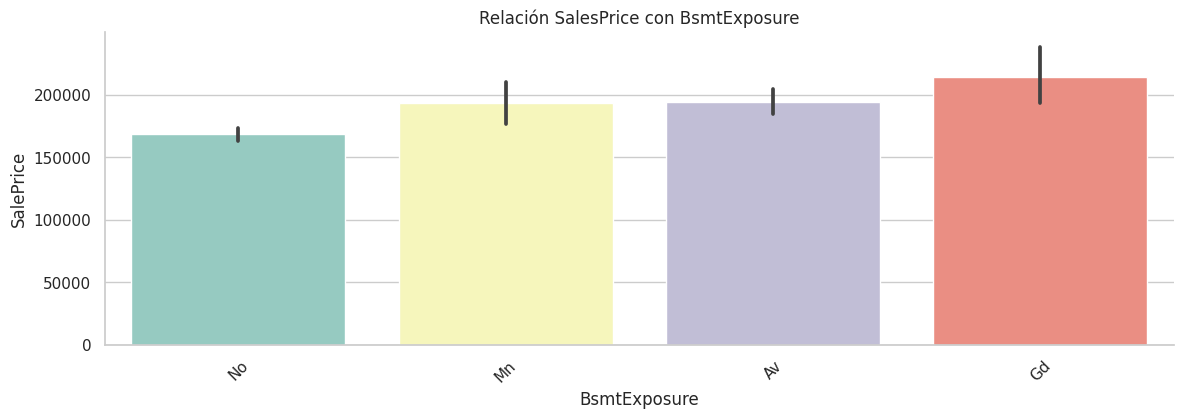

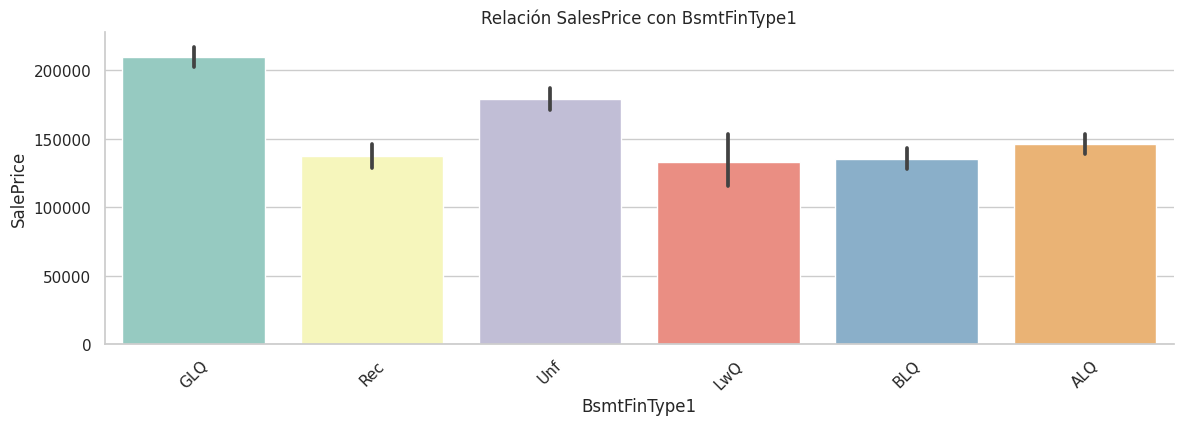

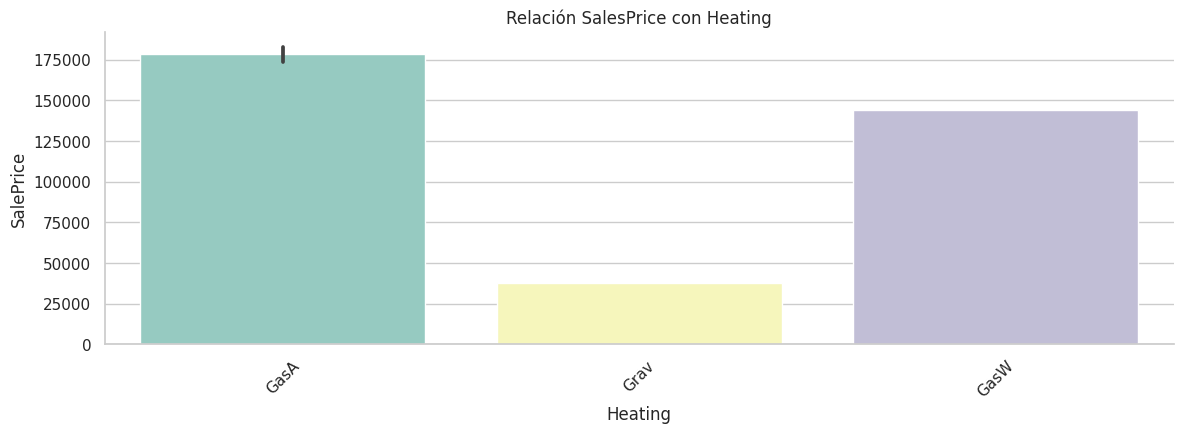

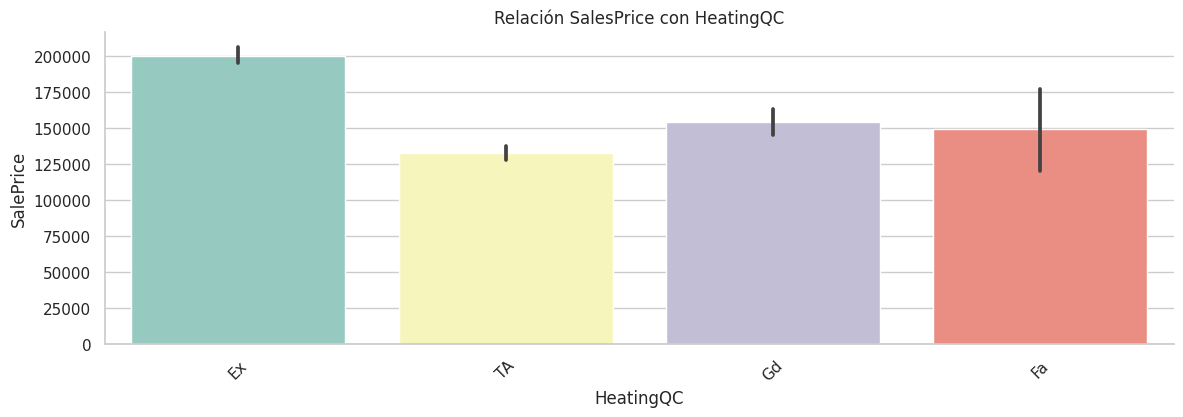

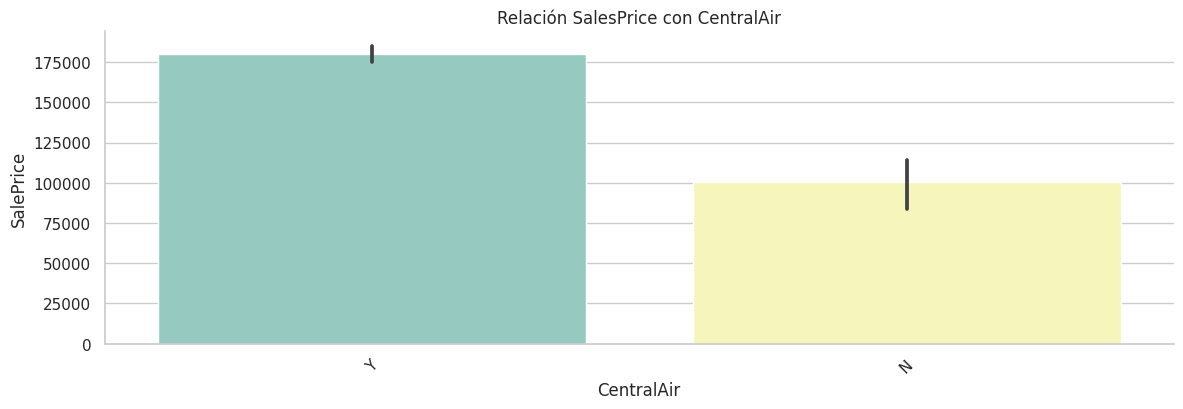

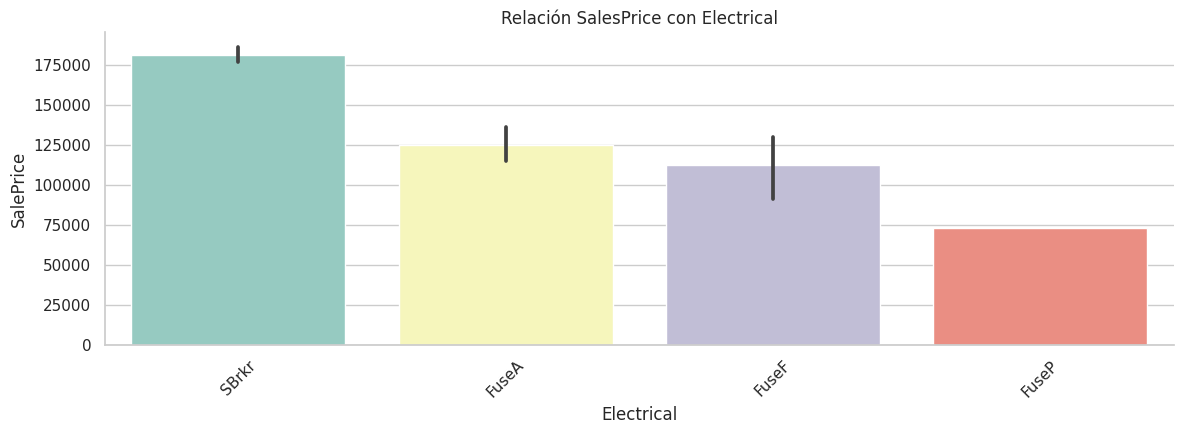

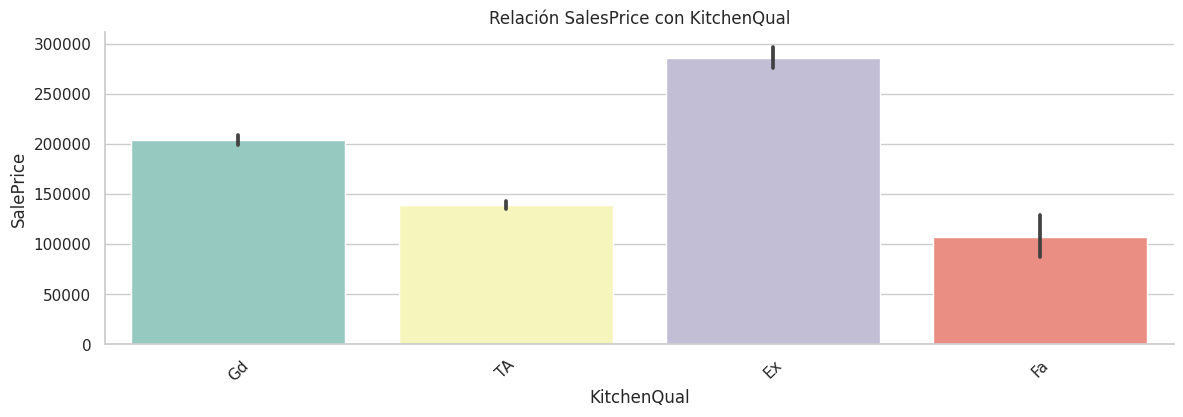

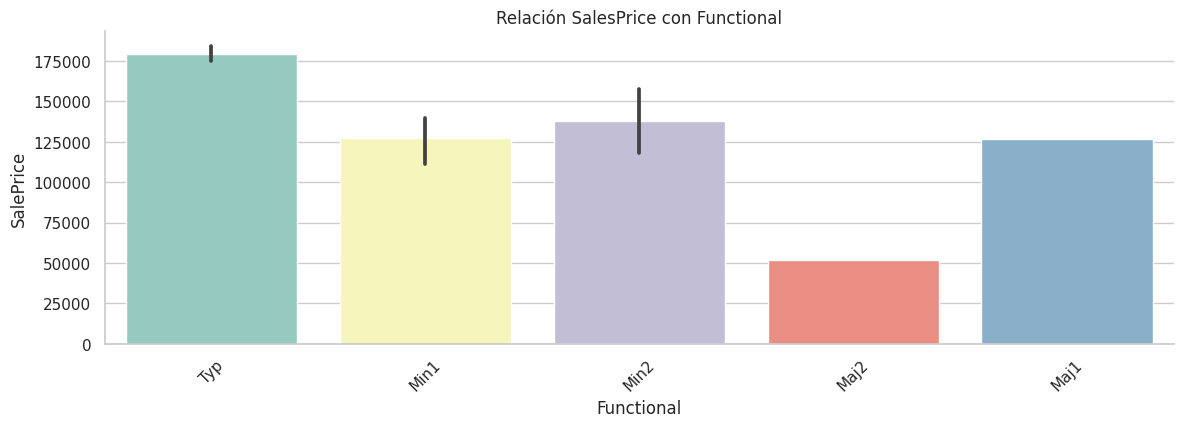

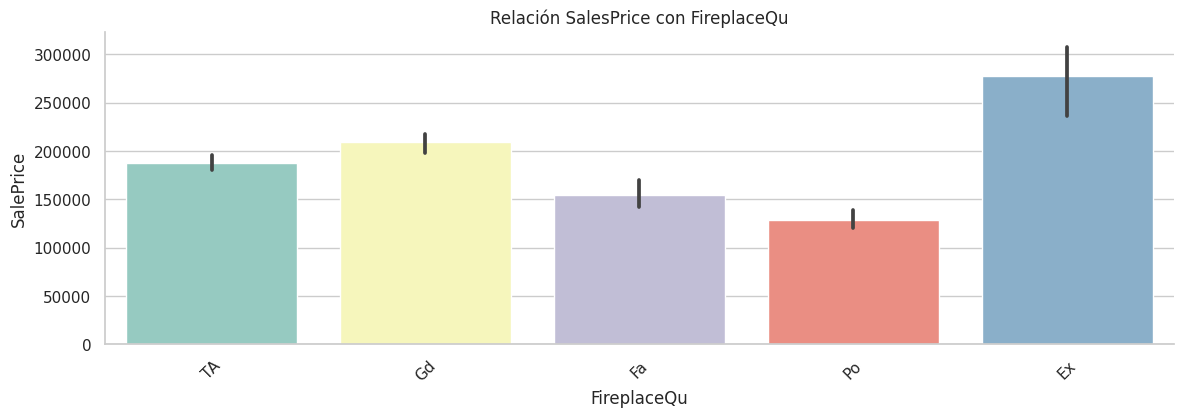

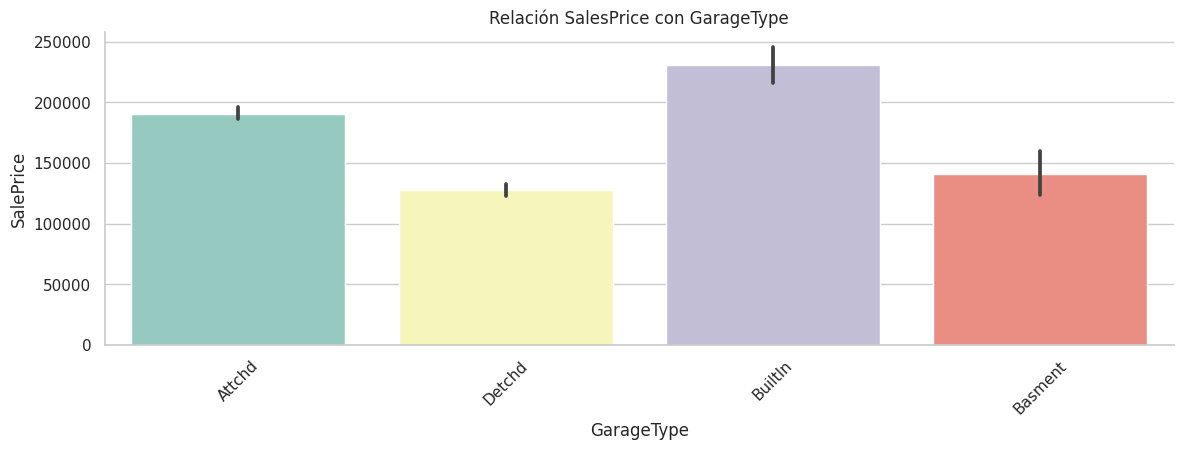

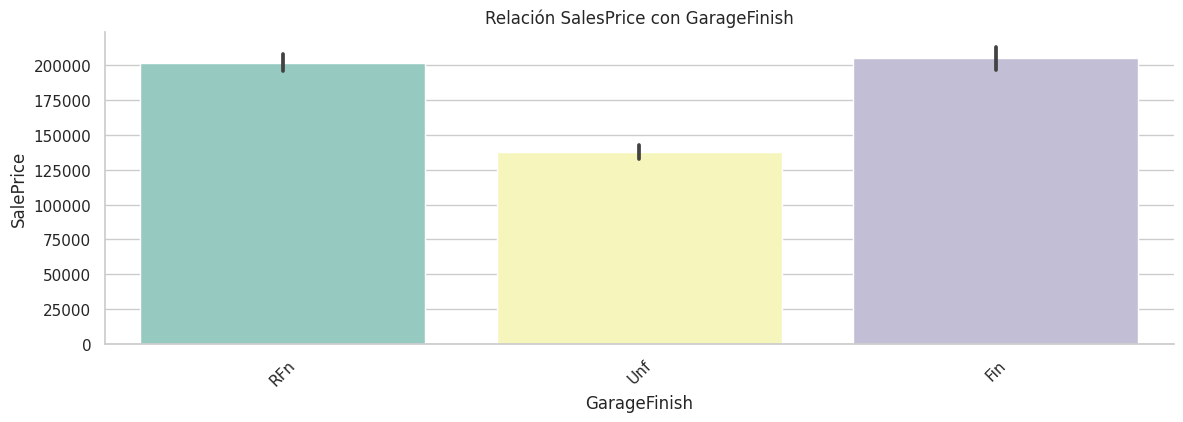

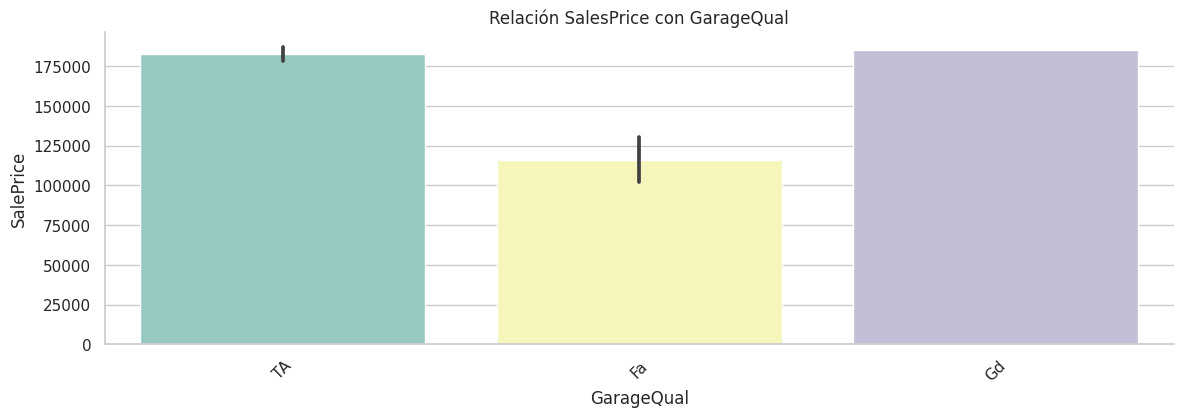

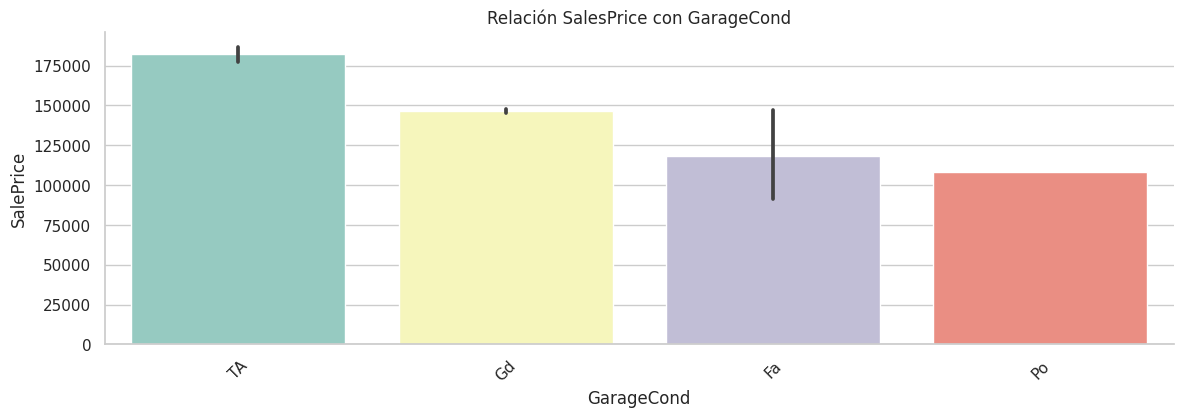

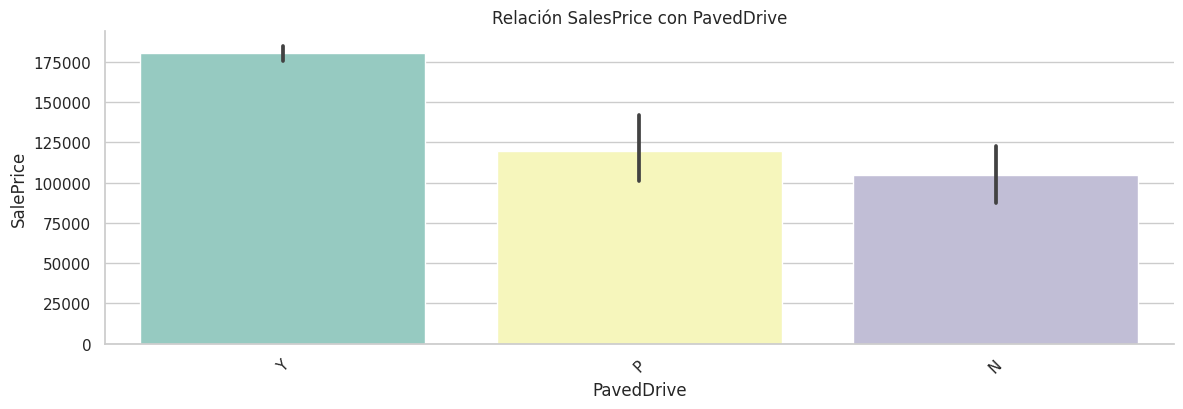

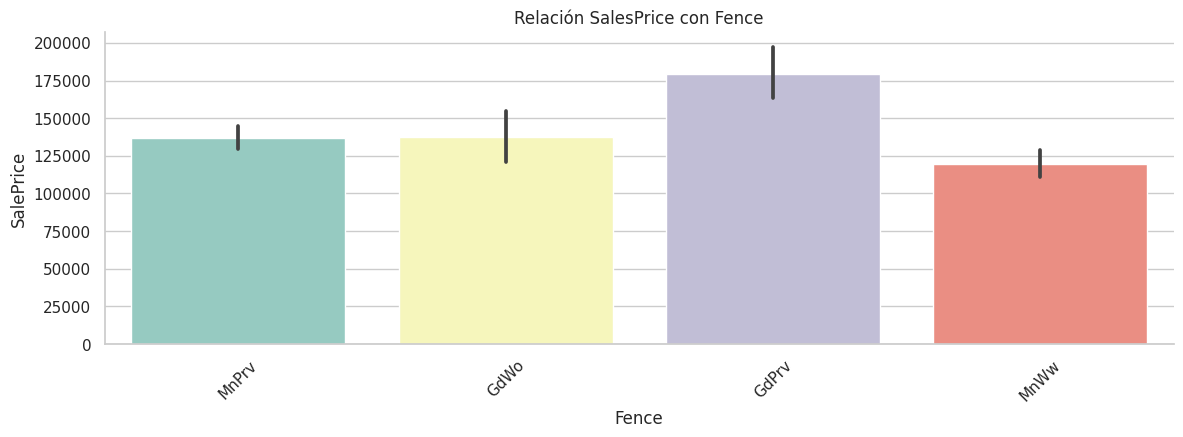

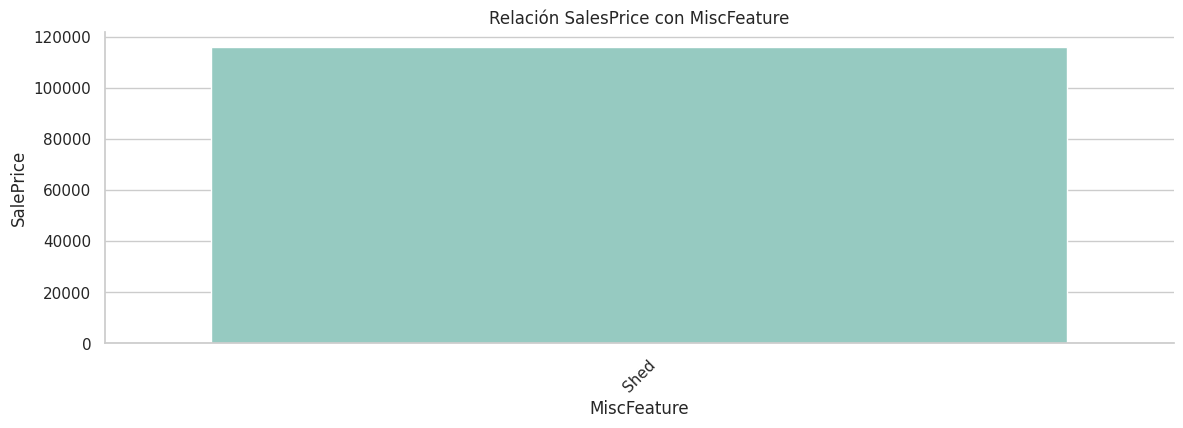

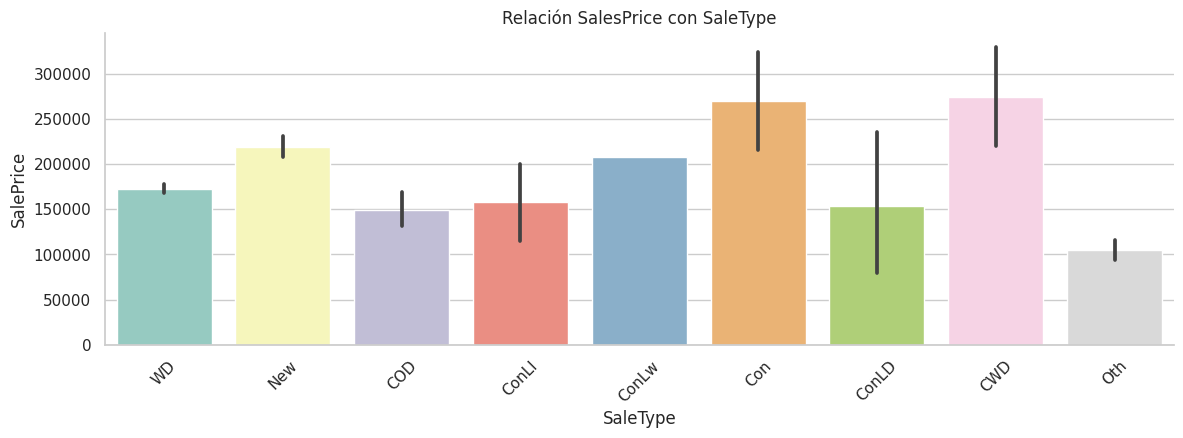

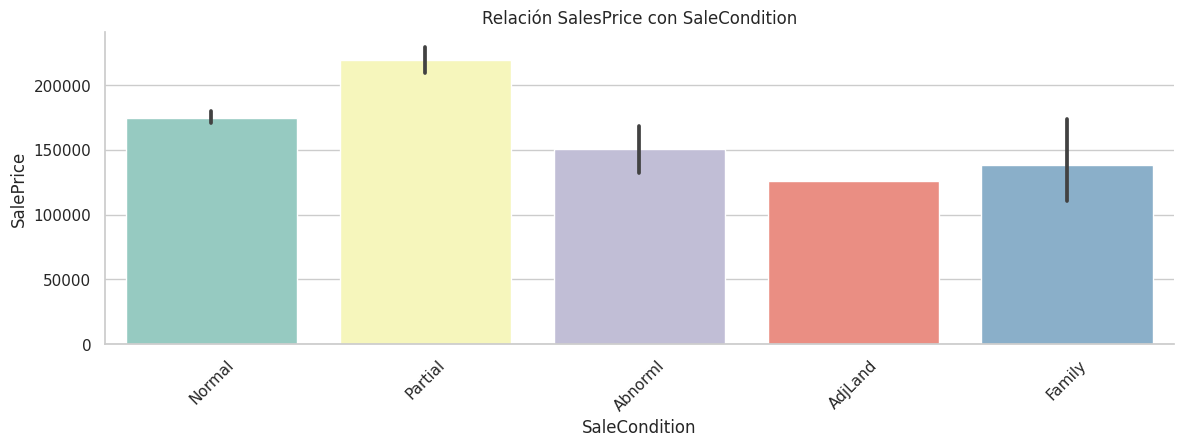

In [ ]:
#Graficar relación variables (bivarible)
for col in categorical_columns:
  sns.catplot(x=col, y="SalePrice", kind="bar", dodge=False, height = 4, aspect = 3,  data=df_train, palette="Set3")
  plt.xticks(rotation=45)
  plt.title("Relación SalesPrice con " + col)

Analicemos la presencia de valores NA/caracteristica

In [ ]:
#Para variables categóricas
total_categorical = len(df_train)
nulls_categorical = (df_train[categorical_columns].isnull().sum() / total_categorical) * 100
print("\nPorcentaje de valores nulos para variables categóricas:")
print(nulls_categorical)


Porcentaje de valores nulos para variables categóricas:
MSZoning          0.000000
Street            0.000000
Alley            96.167883
LotShape          0.000000
LandContour       0.000000
LotConfig         0.000000
LandSlope         0.000000
Neighborhood      0.000000
Condition1        0.000000
BldgType          0.000000
HouseStyle        0.000000
RoofStyle         0.000000
Exterior1st       0.000000
Exterior2nd       0.000000
MasVnrType        0.912409
ExterQual         0.000000
ExterCond         0.000000
Foundation        0.000000
BsmtQual          0.000000
BsmtCond          0.000000
BsmtExposure      0.182482
BsmtFinType1      0.000000
Heating           0.000000
HeatingQC         0.000000
CentralAir        0.000000
Electrical        0.182482
KitchenQual       0.000000
Functional        0.000000
FireplaceQu      50.000000
GarageType        4.014599
GarageFinish      4.014599
GarageQual        4.014599
GarageCond        4.014599
PavedDrive        0.000000
Fence            82.84671

Existen variables con porcentajes de valores nulos muy altos, estas son:
* Alley: 96.167% -> Candidato a eliminar
* MasVnrType (Tipo de revestimiento de mampostería): 0,91% -> Candidato a imputar
* BsmtExposure: 0.18% -> Candiato a imputar
* Electrical: 0.18% -> Candiato a imputar
* FireplaceQu (Calidad de chimenea): 50.00% -> Candidato a imputar
* Fence: 82.84% -> Candidato a eliminar
* MiscFeature: 99.81% -> Candidato a eliminar

In [ ]:
#Lista de etiquetas de columnas
etiquetas_columnas = ['Alley','Fence','MiscFeature']
#Iterar sobre las etiquetas de columnas
for etiqueta_columna in etiquetas_columnas:
    conteo_categorias = df_train[etiqueta_columna].value_counts()
    # Imprimir el resultado
    print(f"Value Counts para la columna '{etiqueta_columna}':\n{conteo_categorias}\n")

Value Counts para la columna 'Alley':
Grvl    12
Pave     9
Name: Alley, dtype: int64

Value Counts para la columna 'Fence':
MnPrv    52
GdWo     22
GdPrv    16
MnWw      4
Name: Fence, dtype: int64

Value Counts para la columna 'MiscFeature':
Shed    1
Name: MiscFeature, dtype: int64



In [ ]:
#Columnas a eliminar según análisis previo
categorical_columns = [elemento for elemento in categorical_columns if elemento not in etiquetas_columnas]

In [ ]:
#Imputación para variables categóricas mediante la moda
for column in categorical_columns:
    if df_train[column].isnull().sum() > 0:  # Verifica si hay valores nulos en la columna
        if df_train[column].dtype == 'object' or df_train[column].dtype.name == 'category':
            most_common_value = df_train[column].mode()[0]
            df_train[column].fillna(most_common_value, inplace=True)

In [ ]:
#Para variables categóricas
total_categorical = len(df_train)
nulls_categorical = (df_train[categorical_columns].isnull().sum() / total_categorical) * 100
print("\nPorcentaje de valores nulos para variables categóricas:")
print(nulls_categorical)


Porcentaje de valores nulos para variables categóricas:
MSZoning         0.0
Street           0.0
LotShape         0.0
LandContour      0.0
LotConfig        0.0
LandSlope        0.0
Neighborhood     0.0
Condition1       0.0
BldgType         0.0
HouseStyle       0.0
RoofStyle        0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
ExterQual        0.0
ExterCond        0.0
Foundation       0.0
BsmtQual         0.0
BsmtCond         0.0
BsmtExposure     0.0
BsmtFinType1     0.0
Heating          0.0
HeatingQC        0.0
CentralAir       0.0
Electrical       0.0
KitchenQual      0.0
Functional       0.0
FireplaceQu      0.0
GarageType       0.0
GarageFinish     0.0
GarageQual       0.0
GarageCond       0.0
PavedDrive       0.0
SaleType         0.0
SaleCondition    0.0
dtype: float64


##2 - **Modelado con Regresión Lasso**

###**One-hot encoding**


In [ ]:
#Lista de columnas que quieres mantener
columnas_a_mantener = numeric_columns + categorical_columns
#Filtrar el DataFrame para mantener solo las columnas deseadas
df_train = df_train[columnas_a_mantener]

In [ ]:
categorical_columns

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [ ]:
#Aplicar One-Hot Encoding a las columnas categóricas
df_dumm = pd.get_dummies(df_train, columns=categorical_columns,drop_first=True)
#Visualizar el DataFrame con las nuevas variables dummy
df_dumm.head(5)

YearRemodAdd  TotalBsmtSF  FullBath  1stFlrSF  TotRmsAbvGrd  GrLivArea  \
0           2003          856         2       856             8       1710   
2           2002          920         2       920             6       1786   
4           2000         1145         2      1145             9       2198   
6           2005         1686         2      1694             7       1694   
10          1965         1040         1      1040             5       1040   

    GarageCars  OverallQual  MasVnrArea  GarageYrBlt  ...  SaleType_ConLD  \
0            2            7       196.0       2003.0  ...               0   
2            2            7       162.0       2001.0  ...               0   
4            3            8       350.0       2000.0  ...               0   
6            2            8       186.0       2004.0  ...               0   
10           1            5         0.0       1965.0  ...               0   

    SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0                0               0             0             0            1   
2                0               0             0             0            1   
4                0               0             0             0            1   
6                0               0             0             0            1   
10               0               0             0             0            1   

    SaleCondition_AdjLand  SaleCondition_Family  SaleCondition_Normal  \
0                       0                     0                     1   
2                       0                     0                     1   
4                       0                     0                     1   
6                       0                     0                     1   
10                      0                     0                     1   

    SaleCondition_Partial  
0                       0  
2                       0  
4                       0  
6                       0  
10                      0  

[5 rows x 155 columns]

###**Train test split**

In [ ]:
#Train test split
from sklearn.model_selection import train_test_split
#Definiendo variable dependiente
y_column = 'SalePrice'
X = df_dumm.drop(["SalePrice"],axis =1)
y = df_dumm["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 102)

###**Escalado**

In [ ]:
#Escalar train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#A dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
#Escalar test
X_test_scaled = scaler.transform(X_test)
#A dataframe
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [ ]:
#Inicializando diccionarios de resultados para train, test y coeficiencias B0 y B1..BN
results_dict_train = {}
results_dict_test = {}
coefs = {}

###**Modelando de datos del train**

In [ ]:
#Entrenamos el modelo
ls_cv = LassoCV(alphas=np.logspace(-8, 8, 17), max_iter=50000)
ls_cv.fit(X=X_train_scaled, y=y_train)
#Guardar coeficientes
coefs['LASSO_CV'] = {}
coefs['LASSO_CV']['B0'] = ls_cv.intercept_
for (i,coef) in enumerate(ls_cv.coef_, start=1):
  coefs['LASSO_CV'][f'B{i}'] = coef

In [ ]:
#Mejor lambda
print(f'El mejor lambda para Lasso es: {ls_cv.alpha_}')

El mejor lambda para Lasso es: 100.0


In [ ]:
#Entrenamos el modelo
ls = Lasso(alpha=100)
ls.fit(X=X_train_scaled, y=y_train)
#Imprimir componentes
print(f'Bi: {ls.coef_}')
print(f'B0: {ls.intercept_}')
#Guardar coeficientes
coefs['LASSO'] = {}
coefs['LASSO']['B0'] = ls.intercept_
for (i,coef) in enumerate(ls.coef_, start=1):
  coefs['LASSO'][f'B{i}'] = coef

Bi: [ 4.30597031e+03  9.81333661e+03  9.71402507e+02 -4.89889832e+03
 -0.00000000e+00  2.09368901e+04  1.34154647e+03  9.51875471e+03
  1.19539282e+03  0.00000000e+00  6.87008854e+03  6.27340318e+03
 -0.00000000e+00  9.35023647e+02 -0.00000000e+00 -8.29642442e+02
  0.00000000e+00 -1.87326851e+03  8.48831437e+02  2.51120167e+02
 -4.58763628e+02 -1.07270391e+03  1.45894555e+03 -1.67358400e+03
 -2.40933854e+02 -1.45653473e+03  0.00000000e+00  9.70438827e+02
 -3.57467809e+02 -1.03788943e+03  2.64289879e+03 -1.69282472e+03
  0.00000000e+00 -3.19116954e+02 -5.38055444e+02  2.03385796e+02
  2.80684176e+02  0.00000000e+00 -6.53289077e+02  1.48588729e+03
  2.71378495e+03 -1.33880880e+03  7.59246026e+02 -0.00000000e+00
 -1.33370052e+03  3.01771282e+03  1.55485984e+03 -4.38700844e+02
  6.80800492e+02  5.78189931e+02  2.10007761e+03  9.77982285e+02
 -7.89277131e+02  1.54984292e+02  1.73645031e+01  0.00000000e+00
 -1.23966603e+03 -2.25303805e+02 -2.56462630e+03  1.48802551e+03
  1.48976521e+03  0.0

In [ ]:
#Predecimos para X_train
df_train_train = pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis = 1).copy()
df_train_train['y_pred'] = ls.predict(X_train_scaled)
df_train_train['residuals'] = (df_train_train[y_column]-df_train_train['y_pred'])
df_train_train.head()

YearRemodAdd  TotalBsmtSF  FullBath  1stFlrSF  TotRmsAbvGrd  GrLivArea  \
0      0.637574     1.176597  0.771233  1.100317     -0.226875   0.005297   
1      0.127235    -0.964140  0.771233 -0.996377      0.520277   0.446872   
2     -1.199645    -0.327172 -1.204206 -0.506022     -0.226875  -1.207119   
3      0.433438     1.390014  0.771233  1.313368      0.520277   0.166102   
4      0.382404    -0.757289  0.771233 -0.675110      0.520277   0.913971   

   GarageCars  OverallQual  MasVnrArea  GarageYrBlt  ...  SaleType_New  \
0    0.233054     0.598509   -0.711094     0.657395  ...     -0.371029   
1    0.233054    -0.205623   -0.711094     0.242365  ...     -0.371029   
2   -1.246330    -1.009754   -0.711094    -0.956613  ...     -0.371029   
3    0.233054    -0.205623    1.300251     0.472937  ...     -0.371029   
4    0.233054    -0.205623   -0.711094     0.472937  ...     -0.371029   

   SaleType_Oth  SaleType_WD  SaleCondition_AdjLand  SaleCondition_Family  \
0     -0.047836     0.454545              -0.047836             -0.096003   
1     -0.047836     0.454545              -0.047836             -0.096003   
2     -0.047836     0.454545              -0.047836             -0.096003   
3     -0.047836     0.454545              -0.047836             -0.096003   
4     -0.047836     0.454545              -0.047836             -0.096003   

   SaleCondition_Normal  SaleCondition_Partial  SalePrice         y_pred  \
0              0.490707                 -0.375     187100  188793.677303   
1              0.490707                 -0.375     175900  178631.078831   
2              0.490707                 -0.375     127000  121580.176602   
3              0.490707                 -0.375     208900  213654.591369   
4              0.490707                 -0.375     204750  204700.333045   

     residuals  
0 -1693.677303  
1 -2731.078831  
2  5419.823398  
3 -4754.591369  
4    49.666955  

[5 rows x 157 columns]

In [ ]:
#Predecimos para X_test
df_train_test = pd.concat([X_test_scaled, y_test.reset_index(drop=True)], axis = 1).copy()
df_train_test['y_pred'] = ls.predict(X_test_scaled)
df_train_test['residuals'] = (df_train_test[y_column]-df_train_test['y_pred'])
df_train_test.head()

YearRemodAdd  TotalBsmtSF  FullBath  1stFlrSF  TotRmsAbvGrd  GrLivArea  \
0      0.841709    -1.072490  0.771233 -1.273682      1.267429   0.071661   
1      0.127235    -0.481489  0.771233 -0.600711      1.267429   1.243238   
2     -0.995510    -0.172855 -1.204206 -0.347079     -0.974027  -1.087153   
3      0.382404     0.825280  0.771233  0.680978      0.520277   2.123835   
4      0.943777     1.189731  0.771233  1.093553     -0.226875   0.000192   

   GarageCars  OverallQual  MasVnrArea  GarageYrBlt  ...  SaleType_New  \
0    0.233054     0.598509   -0.711094     0.887968  ...      2.695209   
1    0.233054     1.402640   -0.711094     0.242365  ...     -0.371029   
2    0.233054    -1.009754   -0.000107    -0.633812  ...     -0.371029   
3    0.233054     0.598509   -0.711094     0.426823  ...     -0.371029   
4    0.233054     0.598509    1.683810     0.980197  ...      2.695209   

   SaleType_Oth  SaleType_WD  SaleCondition_AdjLand  SaleCondition_Family  \
0     -0.047836    -2.200000              -0.047836             -0.096003   
1     -0.047836     0.454545              -0.047836             -0.096003   
2     -0.047836     0.454545              -0.047836             -0.096003   
3     -0.047836     0.454545              -0.047836             -0.096003   
4     -0.047836    -2.200000              -0.047836             -0.096003   

   SaleCondition_Normal  SaleCondition_Partial  SalePrice         y_pred  \
0             -2.037877               2.666667     155835  182329.350512   
1             -2.037877              -0.375000     220000  213121.596466   
2              0.490707              -0.375000     148500  150332.952215   
3              0.490707              -0.375000     328000  268158.733928   
4             -2.037877               2.666667     227680  236593.083030   

      residuals  
0 -26494.350512  
1   6878.403534  
2  -1832.952215  
3  59841.266072  
4  -8913.083030  

[5 rows x 157 columns]

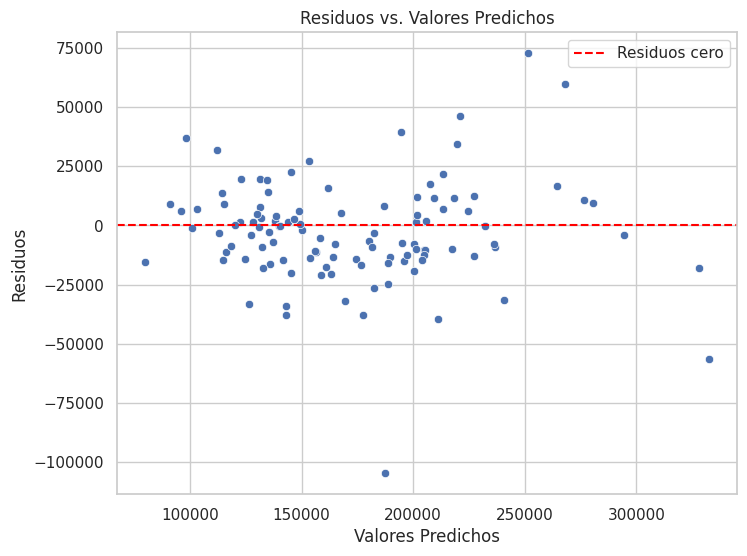

In [ ]:
# Graficar residuos vs y_pred para test
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_train_test["y_pred"], y=df_train_test["residuals"])
plt.axhline(y=0, color='red', linestyle='--', label='Residuos cero')
plt.title('Residuos vs. Valores Predichos')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.legend()
plt.show()

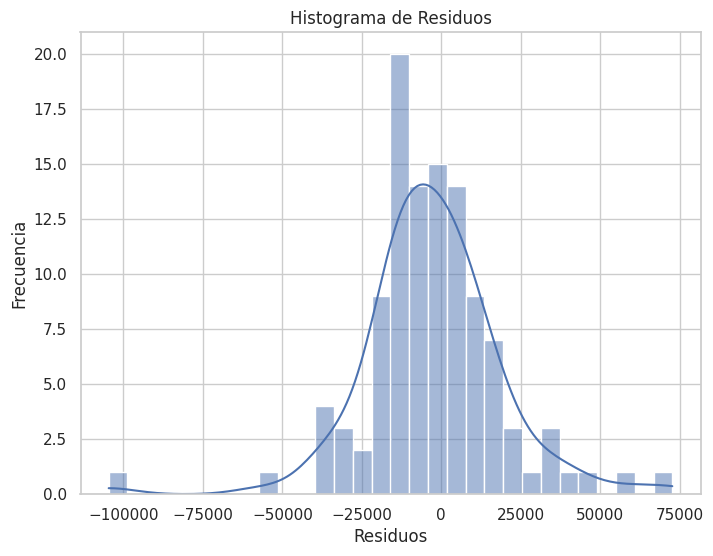

In [ ]:
# Graficar histograma de residuos
plt.figure(figsize=(8, 6))
sns.histplot(df_train_test["residuals"], bins=30, kde=True)
plt.title('Histograma de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

El gráfico anterior muestra una distribución que tiende a ser normal de los residuos para la estimación de test (20% de entrenamiento), significa que los residuos del modelo de regresión se distribuyen de manera aproximadamente normal alrededor de cero que a su vez sugiere que el modelo de regresión está reteniendo la variabilidad en los datos, y los residuos no muestran patrones sistemáticos grandes

In [ ]:
#Métricas de TRAIN
mse_train = metrics.mean_squared_error(df_train_train[y_column], df_train_train['y_pred'])
r2_train = metrics.r2_score(df_train_train[y_column], df_train_train['y_pred'])
rmse_train = np.sqrt(mse_train)
#Métricas de TEST
mse_test = metrics.mean_squared_error(df_train_test[y_column], df_train_test['y_pred'])
r2_test = metrics.r2_score(df_train_test[y_column], df_train_test['y_pred'])
rmse_test = np.sqrt(mse_test)
#Crear el DataFrame
data = {
    'MSE': [mse_train, mse_test],
    'R^2': [r2_train, r2_test],
    'RMSE': [rmse_train, rmse_test]
}
df_results = pd.DataFrame(data, index=['Train', 'Test'])
df_results

MSE       R^2          RMSE
Train  1.264730e+08  0.957033  11246.021868
Test   4.829266e+08  0.836646  21975.589981

##3 - **Predicción de modelo con test data**

Evaluando ahora con la data de test, pero antes debemos encargarnos de prepararla para la prueba repitiendo pasos como la eliminación de NAs, selección de columnas y codificando one-hot

In [ ]:
#Extraer Ids de la data de test (se utilizarán despues para armar el resultad)
Ids = df_test.pop('Id')

In [ ]:
#Definiendo columnas numericas al escenario de entrenamiento del modelo
numeric_columns2 = numeric_columns
numeric_columns2.remove("SalePrice")
#Definiendo columnas categoricas al escenario de entrenamiento del modelo
categorical_columns2 = categorical_columns
columnas_a_mantener2 = numeric_columns2 + categorical_columns2
#Ajuste final
df_test = df_test[columnas_a_mantener2]

In [ ]:
df_test.head(5)

YearRemodAdd  TotalBsmtSF  FullBath  1stFlrSF  TotRmsAbvGrd  GrLivArea  \
0          1961        882.0         1       896             5        896   
1          1958       1329.0         1      1329             6       1329   
2          1998        928.0         2       928             6       1629   
3          1998        926.0         2       926             7       1604   
4          1992       1280.0         2      1280             5       1280   

   GarageCars  OverallQual  MasVnrArea  GarageYrBlt  ...  KitchenQual  \
0         1.0            5         0.0       1961.0  ...           TA   
1         1.0            6       108.0       1958.0  ...           Gd   
2         2.0            5         0.0       1997.0  ...           TA   
3         2.0            6        20.0       1998.0  ...           Gd   
4         2.0            8         0.0       1992.0  ...           Gd   

   Functional FireplaceQu GarageType GarageFinish GarageQual GarageCond  \
0         Typ         NaN     Attchd          Unf         TA         TA   
1         Typ         NaN     Attchd          Unf         TA         TA   
2         Typ          TA     Attchd          Fin         TA         TA   
3         Typ          Gd     Attchd          Fin         TA         TA   
4         Typ         NaN     Attchd          RFn         TA         TA   

  PavedDrive SaleType SaleCondition  
0          Y       WD        Normal  
1          Y       WD        Normal  
2          Y       WD        Normal  
3          Y       WD        Normal  
4          Y       WD        Normal  

[5 rows x 47 columns]

In [ ]:
#Imputación para variables numéricas mediante la mediana
for column in numeric_columns2:
    if df_test[column].isnull().sum() > 0:
        if df_test[column].dtype == 'int64' or df_test[column].dtype == 'float64':
            median_value = df_test[column].median()
            df_test[column].fillna(median_value, inplace=True)

#Imputación para variables categóricas mediante la moda
for column in categorical_columns2:
    if df_test[column].isnull().sum() > 0:  # Verifica si hay valores nulos en la columna
        if df_test[column].dtype == 'object' or df_test[column].dtype.name == 'category':
            most_common_value = df_test[column].mode()[0]
            df_test[column].fillna(most_common_value, inplace=True)

<ipython-input-48-d951eb606463>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[column].fillna(median_value, inplace=True)
<ipython-input-48-d951eb606463>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[column].fillna(median_value, inplace=True)
<ipython-input-48-d951eb606463>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[column].fillna(median_value, inplace=True)
<ipython-input-48-d951eb606463>:6: SettingW

In [ ]:
#Aplicar One-Hot Encoding a las columnas categóricas
df_dumm_test = pd.get_dummies(df_test, columns=categorical_columns2,drop_first=True)
#Visualizar el DataFrame con las nuevas variables dummy
df_dumm_test.head(5)

YearRemodAdd  TotalBsmtSF  FullBath  1stFlrSF  TotRmsAbvGrd  GrLivArea  \
0          1961        882.0         1       896             5        896   
1          1958       1329.0         1      1329             6       1329   
2          1998        928.0         2       928             6       1629   
3          1998        926.0         2       926             7       1604   
4          1992       1280.0         2      1280             5       1280   

   GarageCars  OverallQual  MasVnrArea  GarageYrBlt  ...  SaleType_ConLI  \
0         1.0            5         0.0       1961.0  ...               0   
1         1.0            6       108.0       1958.0  ...               0   
2         2.0            5         0.0       1997.0  ...               0   
3         2.0            6        20.0       1998.0  ...               0   
4         2.0            8         0.0       1992.0  ...               0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     1                      0  
4                     1                      0  

[5 rows x 184 columns]

La dimensionalidad es distintas, esto puede ser ocasionado por presencia de categorías no observadas durante el entrenamiento con la data df_train, por lo tanto se escalará la data y se verificará que la dimensión sea la correcta tomando como referencia los parámetros utilizados durante el entranmiento

In [ ]:
#Definiendo variable dependiente
X_test = df_dumm_test
#Escalar train
scaler = StandardScaler()
#Escalar test
X_test_scaled = scaler.fit_transform(X_test)
#A dataframe
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [ ]:
#Ajustando las columnas
X_test_scaled = X_test_scaled.reindex(columns=df_train_test.columns, fill_value=None)
X_test_scaled = X_test_scaled.drop(["SalePrice","y_pred","residuals"], axis=1)

In [ ]:
#Predecimos para df_test con lasso (ls)
df_test = pd.concat([X_test_scaled, y_test.reset_index(drop=True)], axis = 1).copy()
df_test['SalePrice'] = ls.predict(X_test_scaled)
df_test.head()

YearRemodAdd  TotalBsmtSF  FullBath  1stFlrSF  TotRmsAbvGrd  GrLivArea  \
0     -1.072885    -0.370716 -1.028720 -0.654561     -0.918335  -1.215588   
1     -1.214908     0.639230 -1.028720  0.433298     -0.255371  -0.323539   
2      0.678742    -0.266784  0.773083 -0.574165     -0.255371   0.294508   
3      0.678742    -0.271303  0.773083 -0.579190      0.407593   0.243004   
4      0.394694     0.528520  0.773083  0.310192     -0.918335  -0.424487   

   GarageCars  OverallQual  MasVnrArea  GarageYrBlt  ...  SaleType_ConLI  \
0   -0.988189    -0.751101   -0.563316    -0.653107  ...       -0.052432   
1   -0.988189    -0.054877    0.047057    -0.769806  ...       -0.052432   
2    0.301406    -0.751101   -0.563316     0.747276  ...       -0.052432   
3    0.301406    -0.054877   -0.450284     0.786176  ...       -0.052432   
4    0.301406     1.337571   -0.563316     0.552779  ...       -0.052432   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0       -0.045392     -0.295268     -0.052432     0.398568   
1       -0.045392     -0.295268     -0.052432     0.398568   
2       -0.045392     -0.295268     -0.052432     0.398568   
3       -0.045392     -0.295268     -0.052432     0.398568   
4       -0.045392     -0.295268     -0.052432     0.398568   

   SaleCondition_AdjLand  SaleCondition_Family  SaleCondition_Normal  \
0              -0.074253             -0.134699              0.460211   
1              -0.074253             -0.134699              0.460211   
2              -0.074253             -0.134699              0.460211   
3              -0.074253             -0.134699              0.460211   
4              -0.074253             -0.134699              0.460211   

   SaleCondition_Partial      SalePrice  
0              -0.299365  132697.247486  
1              -0.299365  165720.996822  
2              -0.299365  184806.967847  
3              -0.299365  199276.380315  
4              -0.299365  196435.531948  

[5 rows x 155 columns]

In [ ]:
#Uniendo ID con SalePrices
df_test['Id'] = Ids
df_results_ls = df_test[['Id', 'SalePrice']]
df_results_ls.head(5)

Id      SalePrice
0  1461  132697.247486
1  1462  165720.996822
2  1463  184806.967847
3  1464  199276.380315
4  1465  196435.531948

In [ ]:
#Impresión results
#True: Google Colab | False: Kaggle
if notebook_type == True:
  df_results_ls.to_csv("/content/drive/MyDrive/Colab Notebooks/Módulo 08/Tareas/submission.csv", index=False)
elif notebook_type == False:
  df_results_ls.to_csv("/kaggle/working/submission.csv", index=False)